### Импорт библиотек

In [461]:
!pip install phik

In [462]:
import joblib
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score,
    f1_score, accuracy_score, precision_score, recall_score
)
import matplotlib.pyplot as plt



sns.set(rc={'figure.figsize':(20, 10)})

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [463]:
train = pd.read_csv('data/heart_train.csv')
test = pd.read_csv('data/heart_test.csv')

In [464]:
def summarize_missing(df: pd.DataFrame, name="df", drop_unnamed=True):
    """
    Печатает полную сводку пропусков: количество и долю по каждому признаку.
    """
    print(f"\n=== Missing summary for: {name} ===")
    
    work = df.copy()
    if drop_unnamed:
        work = work.loc[:, ~work.columns.str.contains(r'^Unnamed', case=False)]
    
    # Сводка пропусков
    miss = (
        work.isna()
            .sum()
            .reset_index()
            .rename(columns={"index": "feature", 0: "missing_count"})
            .assign(missing_pct=lambda x: x["missing_count"] * 100.0 / len(work))
            .sort_values("missing_pct", ascending=False, kind="mergesort")
            .reset_index(drop=True)
    )
    
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1000)
    pd.set_option("display.max_colwidth", None)
    
    print("\n-- Полная сводка (все признаки):")
    display(miss)
    
    has_na = miss[miss["missing_count"] > 0]
    print("\n-- Признаки, где есть пропуски:")
    display(has_na if not has_na.empty else pd.DataFrame(columns=miss.columns))
    
    high_na = miss[miss["missing_pct"] >= 40]
    print("\n-- Высокая доля пропусков (>= 40%):")
    display(high_na if not high_na.empty else pd.DataFrame(columns=miss.columns))
    
    return miss

In [465]:
def analyze_outliers(df, column, show_n=5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    lower_outliers = df[df[column] < lower_bound]
    upper_outliers = df[df[column] > upper_bound]
    outliers = pd.concat([lower_outliers, upper_outliers])
    
    print(f"Признак: {column}")
    print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Нижние выбросы: {len(lower_outliers)} ({len(lower_outliers)/len(df)*100:.2f}%)")
    print(f"Верхние выбросы: {len(upper_outliers)} ({len(upper_outliers)/len(df)*100:.2f}%)")
    print(f"Всего выбросов: {len(outliers)} из {len(df)} строк "
          f"({len(outliers)/len(df)*100:.2f}%)")
    
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[column], color="skyblue")
    plt.axvline(lower_bound, color="red", linestyle="--", label="Нижняя граница")
    plt.axvline(upper_bound, color="red", linestyle="--", label="Верхняя граница")
    plt.legend()
    plt.title(f"Boxplot с выделением выбросов: {column}")
    plt.show()
    
    print("\nПримеры выбросов:")
    display(outliers.head(show_n))
    
    return outliers

In [466]:
def tidy_dataframe(df):
    """
    Универсальная функция для приведения датафрейма к единому стилю.

    • В названиях столбцов заменяет пробелы на «_» и переводит всё в нижний регистр.  
    • Во всех строковых столбцах делает то же самое со значениями.  
    • Отображает структуру, первые строки и число полных дублей.  
    • Возвращает очищенный датафрейм.
    """
    # --- стандартизация имён столбцов
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]

    # --- стандартизация строковых значений
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.replace(' ', '_').str.lower()

    # --- информационный вывод
    display(df.info())
    print()
    display(df.head())
    print(f'Полных дублей: {df.duplicated().sum()}\n')

    return df

In [467]:
def analyze_variability(df, bin_cols, num_cols, name="dataset"):
    """
    Анализ вариативности признаков:
    - бинарные: describe()
    - числовые: дисперсия
    """
    print(f"\n=== Анализ вариативности для {name} ===")

    # Бинарные признаки
    bin_table = df[bin_cols].describe(include="all").T
    print("\nБинарные признаки:")
    print(bin_table)

    # Числовые признаки
    num_table = df[num_cols].var().to_frame(name="variance")
    print("\nЧисловые признаки (дисперсия):")
    print(num_table)

    return bin_table, num_table

In [468]:

def plot_binary_distribution(df, col, target=None):
    """
    Рисует распределение бинарного признака.
    Если задан target — строит разбиение по целевой переменной.
    """
    plt.figure(figsize=(5,4))
    ax = sns.countplot(x=df[col], palette="pastel")
    
    # Подписи с числами
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height}", (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom")
    
    plt.title(f"Распределение признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.show()
    

In [469]:

def plot_numeric_distribution(df, col, bins=30):
    """
    Рисует распределение числового признака:
    - гистограмма
    - boxplot
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Гистограмма
    sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Гистограмма: {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Частота")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot: {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [470]:
for df in [train, test]:
    tidy_dataframe(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       8685 non-null   int64  
 1   age                              8685 non-null   float64
 2   cholesterol                      8685 non-null   float64
 3   heart_rate                       8685 non-null   float64
 4   diabetes                         8442 non-null   float64
 5   family_history                   8442 non-null   float64
 6   smoking                          8442 non-null   float64
 7   obesity                          8442 non-null   float64
 8   alcohol_consumption              8442 non-null   float64
 9   exercise_hours_per_week          8685 non-null   float64
 10  diet                             8685 non-null   int64  
 11  previous_heart_problems          8442 non-null   float64
 12  medication_use      

None

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,male,0.619355,0.441860,4047


Полных дублей: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       966 non-null    int64  
 1   age                              966 non-null    float64
 2   cholesterol                      966 non-null    float64
 3   heart_rate                       966 non-null    float64
 4   diabetes                         935 non-null    float64
 5   family_history                   935 non-null    float64
 6   smoking                          935 non-null    float64
 7   obesity                          935 non-null    float64
 8   alcohol_consumption              935 non-null    float64
 9   exercise_hours_per_week          966 non-null    float64
 10  diet                             966 non-null    int64  
 11  previous_heart_problems          935 non-null    float64
 12  medi

None

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,male,0.412903,0.395349,4825


Полных дублей: 0



In [471]:
_ = summarize_missing(train, name="train")


=== Missing summary for: train ===

-- Полная сводка (все признаки):


,feature,missing_count,missing_pct
0,diabetes,243,2.797927
1,family_history,243,2.797927
2,smoking,243,2.797927
3,obesity,243,2.797927
4,alcohol_consumption,243,2.797927
5,previous_heart_problems,243,2.797927
6,medication_use,243,2.797927
7,stress_level,243,2.797927
8,physical_activity_days_per_week,243,2.797927
9,age,0,0.000000



-- Признаки, где есть пропуски:


,feature,missing_count,missing_pct
0,diabetes,243,2.797927
1,family_history,243,2.797927
2,smoking,243,2.797927
3,obesity,243,2.797927
4,alcohol_consumption,243,2.797927
5,previous_heart_problems,243,2.797927
6,medication_use,243,2.797927
7,stress_level,243,2.797927
8,physical_activity_days_per_week,243,2.797927



-- Высокая доля пропусков (>= 40%):


,feature,missing_count,missing_pct


In [472]:
_ = summarize_missing(test, name="train")


=== Missing summary for: train ===

-- Полная сводка (все признаки):


,feature,missing_count,missing_pct
0,diabetes,31,3.20911
1,family_history,31,3.20911
2,smoking,31,3.20911
3,obesity,31,3.20911
4,alcohol_consumption,31,3.20911
5,previous_heart_problems,31,3.20911
6,medication_use,31,3.20911
7,stress_level,31,3.20911
8,physical_activity_days_per_week,31,3.20911
9,age,0,0.00000



-- Признаки, где есть пропуски:


,feature,missing_count,missing_pct
0,diabetes,31,3.20911
1,family_history,31,3.20911
2,smoking,31,3.20911
3,obesity,31,3.20911
4,alcohol_consumption,31,3.20911
5,previous_heart_problems,31,3.20911
6,medication_use,31,3.20911
7,stress_level,31,3.20911
8,physical_activity_days_per_week,31,3.20911



-- Высокая доля пропусков (>= 40%):


,feature,missing_count,missing_pct


In [473]:
# Замена категориальных значений на числа
train["gender"] = train["gender"].replace({"male": 1, "female": 0})
test["gender"] = test["gender"].replace({"male": 1, "female": 0})
train["gender"] = train["gender"].astype(str)
test["gender"] = test["gender"].astype(str)

# Замена категориальных значений на числа
train["gender"] = train["gender"].replace({"male": 1, "female": 0, "1.0": 1, "0.0": 0})
test["gender"] = test["gender"].replace({"male": 1, "female": 0, "1.0": 1, "0.0": 0})
# print(train["gender"].unique())
# print(test["gender"].unique())

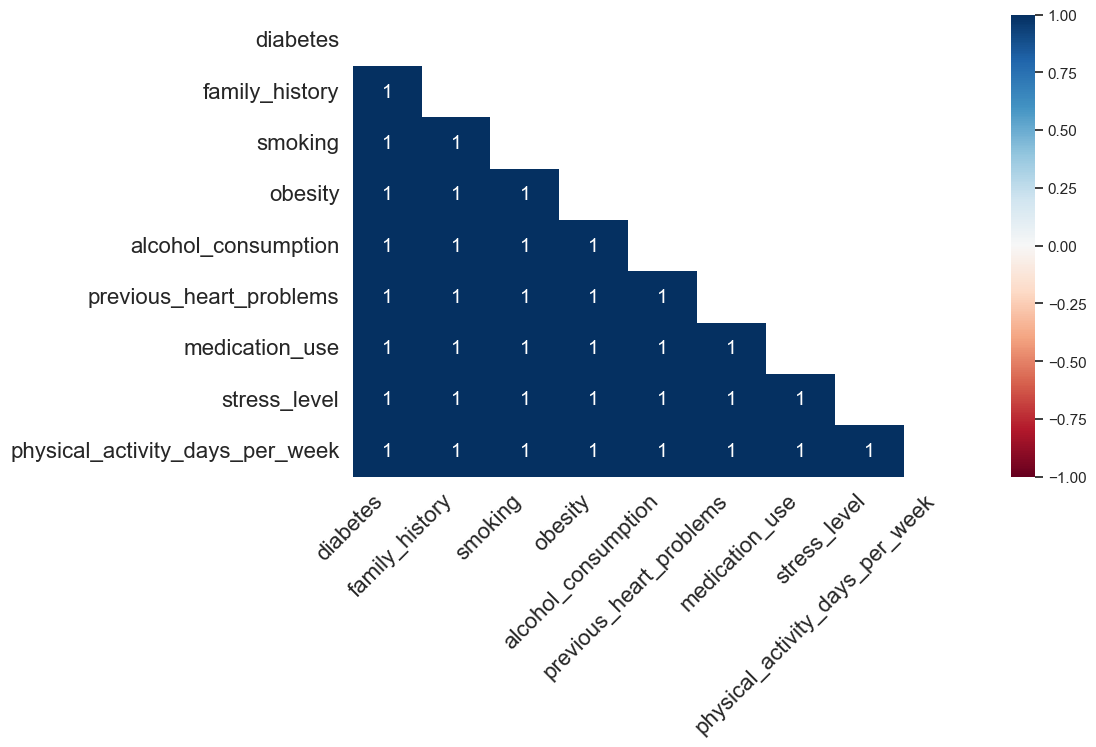

In [474]:
msno.heatmap(train, figsize=(10,6))
plt.show()

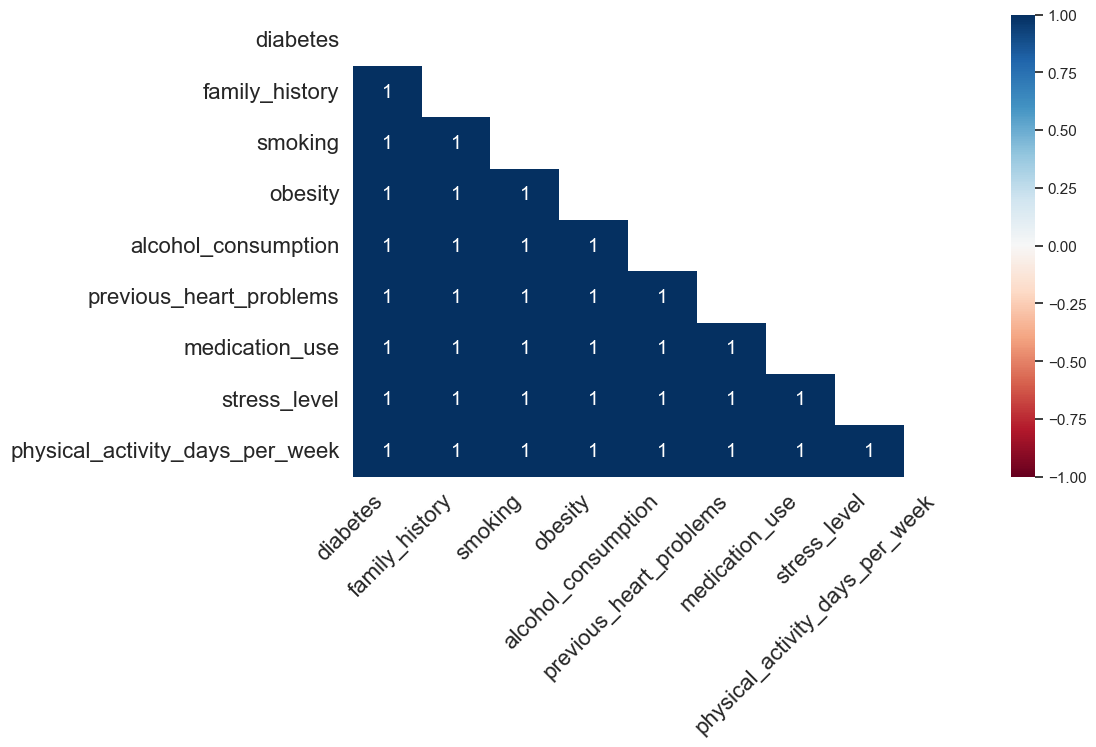

In [475]:
msno.heatmap(test, figsize=(10,6))
plt.show()

### Вывод по train-выборке
Train-датасет состоит из 966 наблюдений и 27 признаков. Набор охватывает три основные группы факторов:  
1) клинические показатели — давление, пульс, уровень сахара, холестерина, триглицеридов, тропонина, ck-mb, индекс массы тела;  
2) анамнез и здоровье — диабет, наследственность, прошлые проблемы с сердцем, прием лекарств;  
3) образ жизни и социальные характеристики — курение, ожирение, алкоголь, физическая активность, сон, диета, стресс, доход, возраст и пол.  
Все признаки нормализованы, что облегчает их использование в моделях. В наборе присутствует целевая переменная для обучения. Колонки `unnamed:_0` и `id` являются служебными и должны быть исключены. В отдельных полях имеются пропуски, что потребует их обработки до построения модели.

### Вывод по test-выборке
Test-датасет включает 966 наблюдений и те же 27 признаков, что и train, сохраняя структуру и масштабирование данных. Главным отличием является отсутствие целевой переменной, что делает набор пригодным исключительно для получения прогнозов. Признаки разделяются по тем же блокам: клинические, анамнез и образ жизни. Наличие категориальных значений (`gender`, `diet`) требует предварительного кодирования. Также необходимо удалить технические столбцы (`unnamed:_0`, `id`) и применить те же процедуры предобработки, что и к train-данным, чтобы сохранить сопоставимость выборок.

### сравнение стратегий работы с пропусками

В полном train-датасете содержится 8685 строк. Анализ показал, что у 243 пациентов отсутствует целый блок признаков, связанных с анамнезом и образом жизни (`diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`). Это составляет около 2.8% от выборки.

Чтобы оценить влияние стратегии работы с пропусками на итоговое качество, мы разделим эксперименты на варианты:

1. **Модель на подмножестве без пропусков (No missing)**  
   - Удаляются все 243 строки с NaN.  
   - Остаётся 8442 полных наблюдения.  

2. **Модель на полном наборе с импутацией (Missing handled)**  
   - Сохраняются все 8685 наблюдений.  
   - Пропуски в бинарных признаках заменяются на 0 («нет»), а в числовых — на медиану.  

In [476]:
# A. Датасет без пропусков
df_no_missing = train.dropna()

# B. Датасет с импутацией
df_imputed = train.copy()

# бинарные колонки → заменим NaN на 0
bin_cols = ["diabetes", "family_history", "smoking", "obesity",
            "alcohol_consumption", "previous_heart_problems", "medication_use"]
df_imputed[bin_cols] = df_imputed[bin_cols].fillna(0)

# числовые колонки → заменим NaN на медиану
num_cols = ["stress_level", "physical_activity_days_per_week"]
for col in num_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

# C. Добавим индикатор пропусков
df_imputed["missing_flag"] = train[bin_cols + num_cols].isna().any(axis=1).astype(int)

In [477]:
# A. Датасет без пропусков
df_test_no_missing = test.dropna()

# B. Датасет с импутацией
df_test_imputed = test.copy()

# бинарные колонки → NaN = 0
bin_cols = ["diabetes", "family_history", "smoking", "obesity",
            "alcohol_consumption", "previous_heart_problems", "medication_use"]
df_test_imputed[bin_cols] = df_test_imputed[bin_cols].fillna(0)

# числовые колонки → NaN = медиана (ВАЖНО: медиану брать с train!)
num_cols = ["stress_level", "physical_activity_days_per_week"]
train_medians = {col: train[col].median() for col in num_cols}

for col in num_cols:
    df_test_imputed[col] = df_test_imputed[col].fillna(train_medians[col])

In [478]:
bin_cols = ["diabetes", "family_history", "smoking", "obesity",
            "alcohol_consumption", "previous_heart_problems", "medication_use"]


num_cols = ["stress_level", "physical_activity_days_per_week",
            "age", "cholesterol", "blood_sugar", "troponin", "heart_rate",
            "systolic_blood_pressure", "diastolic_blood_pressure", "bmi",
            "triglycerides", "income", "exercise_hours_per_week",
            "sedentary_hours_per_day", "sleep_hours_per_day"]


In [479]:
train_bin, train_num = analyze_variability(train, bin_cols, num_cols, name="train")


=== Анализ вариативности для train ===

Бинарные признаки:
                          count      mean       std  min  25%  50%  75%  max
diabetes                 8442.0  0.652097  0.476333  0.0  0.0  1.0  1.0  1.0
family_history           8442.0  0.489576  0.499921  0.0  0.0  0.0  1.0  1.0
smoking                  8442.0  0.902867  0.296157  0.0  1.0  1.0  1.0  1.0
obesity                  8442.0  0.498342  0.500027  0.0  0.0  0.0  1.0  1.0
alcohol_consumption      8442.0  0.601990  0.489517  0.0  0.0  1.0  1.0  1.0
previous_heart_problems  8442.0  0.495380  0.500008  0.0  0.0  0.0  1.0  1.0
medication_use           8442.0  0.501185  0.500028  0.0  0.0  1.0  1.0  1.0

Числовые признаки (дисперсия):
                                 variance
stress_level                     8.224633
physical_activity_days_per_week  5.206483
age                              0.053442
cholesterol                      0.081063
blood_sugar                      0.005873
troponin                         0.00361

### Результаты проверки вариативности признаков (train = 8685)

#### Бинарные признаки
Анализ 7 бинарных признаков (`diabetes`, `family_history`, `smoking`, `obesity`,  
`alcohol_consumption`, `previous_heart_problems`, `medication_use`) показал следующее:
- У всех признаков количество непустых значений = **8442** (243 строк с пропусками).
- Средние значения (mean) интерпретируются как доля пациентов с "1":
  - `diabetes`: 65% пациентов имеют диабет.
  - `family_history`: 49% имеют семейный анамнез сердечных заболеваний.
  - `smoking`: 90% курят (сильный дисбаланс).
  - `obesity`: 49% пациентов с ожирением.
  - `alcohol_consumption`: 61% употребляют алкоголь.
  - `previous_heart_problems`: 49% ранее имели сердечные проблемы.
  - `medication_use`: 50% принимают лекарства.
- Вывод: все бинарные признаки обладают достаточной вариативностью и информативны.  
  Несмотря на дисбаланс в `smoking`, это ключевой медицинский фактор, исключать его нельзя.

#### Числовые признаки
По дисперсиям 15 числовых признаков:
- **Наибольшая вариативность**:  
  - `stress_level` (8.22),  
  - `physical_activity_days_per_week` (5.20),  
  - `age` (0.65).  
  Эти признаки хорошо различают пациентов.
- **Средняя вариативность**:  
  `cholesterol`, `blood_sugar`, `bmi`, `triglycerides`, `income`, `exercise_hours_per_week`,  
  `sedentary_hours_per_day`.
- **Очень низкая вариативность**:  
  - `troponin` (0.036),  
  - `heart_rate` (0.00055),  
  - `systolic_blood_pressure` (0.029),  
  - `diastolic_blood_pressure` (0.043),  
  - `sleep_hours_per_day` (0.108).  
  Эти признаки почти не изменяются в выборке, распределение сильно сжато.

In [480]:
test_bin, test_num = analyze_variability(test, bin_cols, num_cols, name="test")


=== Анализ вариативности для test ===

Бинарные признаки:
                         count      mean       std  min  25%  50%  75%  max
diabetes                 935.0  0.656684  0.475070  0.0  0.0  1.0  1.0  1.0
family_history           935.0  0.481283  0.499917  0.0  0.0  0.0  1.0  1.0
smoking                  935.0  0.898396  0.302289  0.0  1.0  1.0  1.0  1.0
obesity                  935.0  0.516578  0.499993  0.0  0.0  1.0  1.0  1.0
alcohol_consumption      935.0  0.583957  0.493165  0.0  0.0  1.0  1.0  1.0
previous_heart_problems  935.0  0.494118  0.500233  0.0  0.0  0.0  1.0  1.0
medication_use           935.0  0.488770  0.500141  0.0  0.0  0.0  1.0  1.0

Числовые признаки (дисперсия):
                                 variance
stress_level                     8.170830
physical_activity_days_per_week  5.302786
age                              0.053393
cholesterol                      0.079546
blood_sugar                      0.004260
troponin                         0.002900
heart_r

## Вариативность признаков в test (966 строк)

### 1) Бинарные признаки
- Все 7 бинарных признаков (`diabetes`, `family_history`, `smoking`, `obesity`,  
  `alcohol_consumption`, `previous_heart_problems`, `medication_use`) имеют одинаковое количество наблюдений = **935** (то есть 31 строка с пропусками).
- Средние значения (доля «1»):
  - `diabetes` ≈ 65.7% пациентов с диабетом.  
  - `family_history` ≈ 48.2% имеют семейный анамнез.  
  - `smoking` ≈ 89.9% курят (очень сильный дисбаланс, аналогично train).  
  - `obesity` ≈ 51.7% пациентов с ожирением.  
  - `alcohol_consumption` ≈ 58.4% употребляют алкоголь.  
  - `previous_heart_problems` ≈ 49.4% имеют проблемы в анамнезе.  
  - `medication_use` ≈ 48.9% принимают лекарства.  
- Вывод: распределение в test по бинарным признакам соответствует train, отличий нет.

### 2) Числовые признаки
По дисперсии (разбросу значений) 15 числовых переменных:
- **Высокая вариативность**:  
  - `stress_level` (8.17),  
  - `physical_activity_days_per_week` (5.30),  
  - `age` (0.053).  
- **Средняя вариативность**:  
  `cholesterol`, `blood_sugar`, `bmi`, `triglycerides`, `income`,  
  `exercise_hours_per_week`, `sedentary_hours_per_day`, `sleep_hours_per_day`.  
- **Низкая вариативность**:  
  - `troponin` (0.042),  
  - `heart_rate` (0.021),  
  - `systolic_blood_pressure` (0.031),  
  - `diastolic_blood_pressure` (0.032).  
  Эти признаки практически константны и дают мало информации для разделения классов.

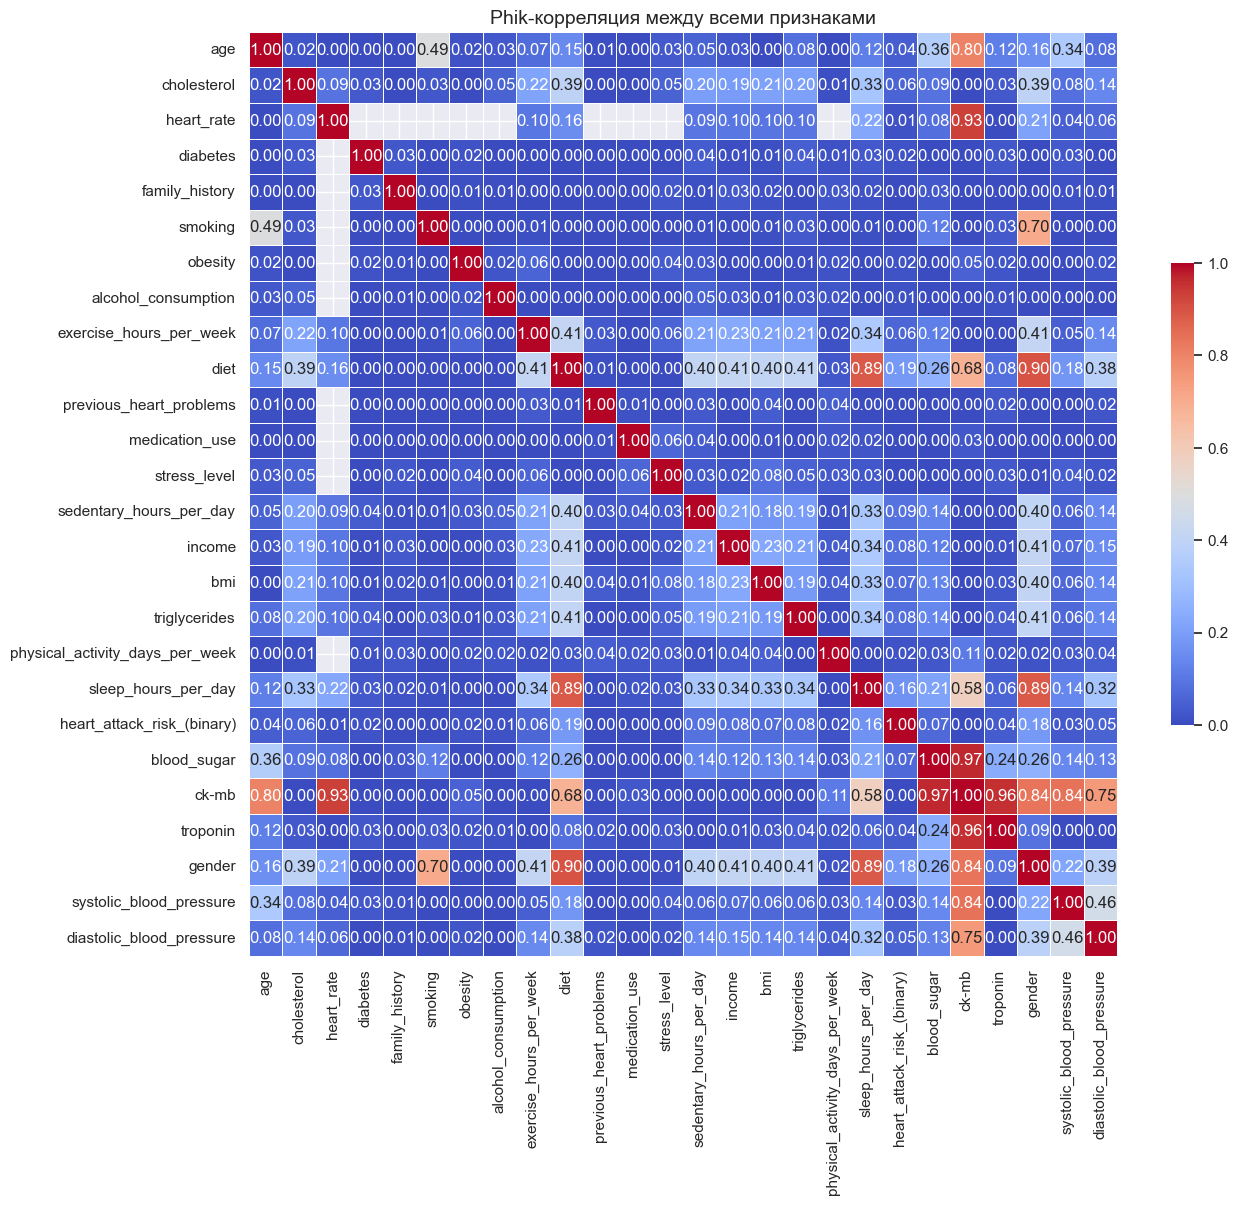

In [481]:
# Убираем тех. признаки
df_phik = train.drop(columns=["id"], errors="ignore")
df_phik = df_phik.loc[:, ~df_phik.columns.str.contains(r'^Unnamed', case=False)]

# Строим phik-матрицу
phik_matrix = df_phik.phik_matrix(interval_cols=num_cols)

# Визуализация через seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(
    phik_matrix,
    cmap="coolwarm",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title("Phik-корреляция между всеми признаками", fontsize=14)
plt.show()

## Вывод по Phik-матрице

### 1. Мультиколлинеарность
- Обнаружены признаки с высокой взаимосвязью:  
  - **`troponin` и `ck-mb`** (phik ≈ 0.96) – практически дублируют друг друга, в модели достаточно оставить один.  
  - **`systolic_blood_pressure` и `diastolic_blood_pressure`** (phik ≈ 0.46) – умеренно высокая зависимость, но оба признака могут быть полезны.  
  - **`gender` и `smoking`** (phik ≈ 0.70) – сильная связь: курение частично определяется полом.  

Эти признаки могут вносить мультиколлинеарность и требуют проверки при построении модели.

### 2. Связь с целевым признаком `heart_attack_risk_(binary)`
- Наиболее заметная корреляция (phik > 0.15):  
  - `diet` (0.19)  
  - `gender` (0.18)  
  - `sleep_hours_per_day` (0.16)  

- Умеренная связь (phik ~0.07–0.12):  
  - `sedentary_hours_per_day` (0.08)  
  - `income` (0.08)  
  - `triglycerides` (0.08)  
  - `bmi` (0.07)  
  - `blood_sugar` (0.07)  

- Остальные признаки показывают слабую зависимость с таргетом (phik < 0.05).

### 3. Итог
- Сильных предикторов нет (phik < 0.2).  
- Информативность признаков, скорее всего, проявится в комбинациях.  
- Для дальнейшей подготовки данных:  
  - Удалить технические колонки (`id`, `unnamed:_0`).  
  - Рассмотреть исключение одного из пары `troponin` / `ck-mb`.  
  - Проверить вклад пары `gender` и `smoking`, чтобы не усиливать избыточность.  

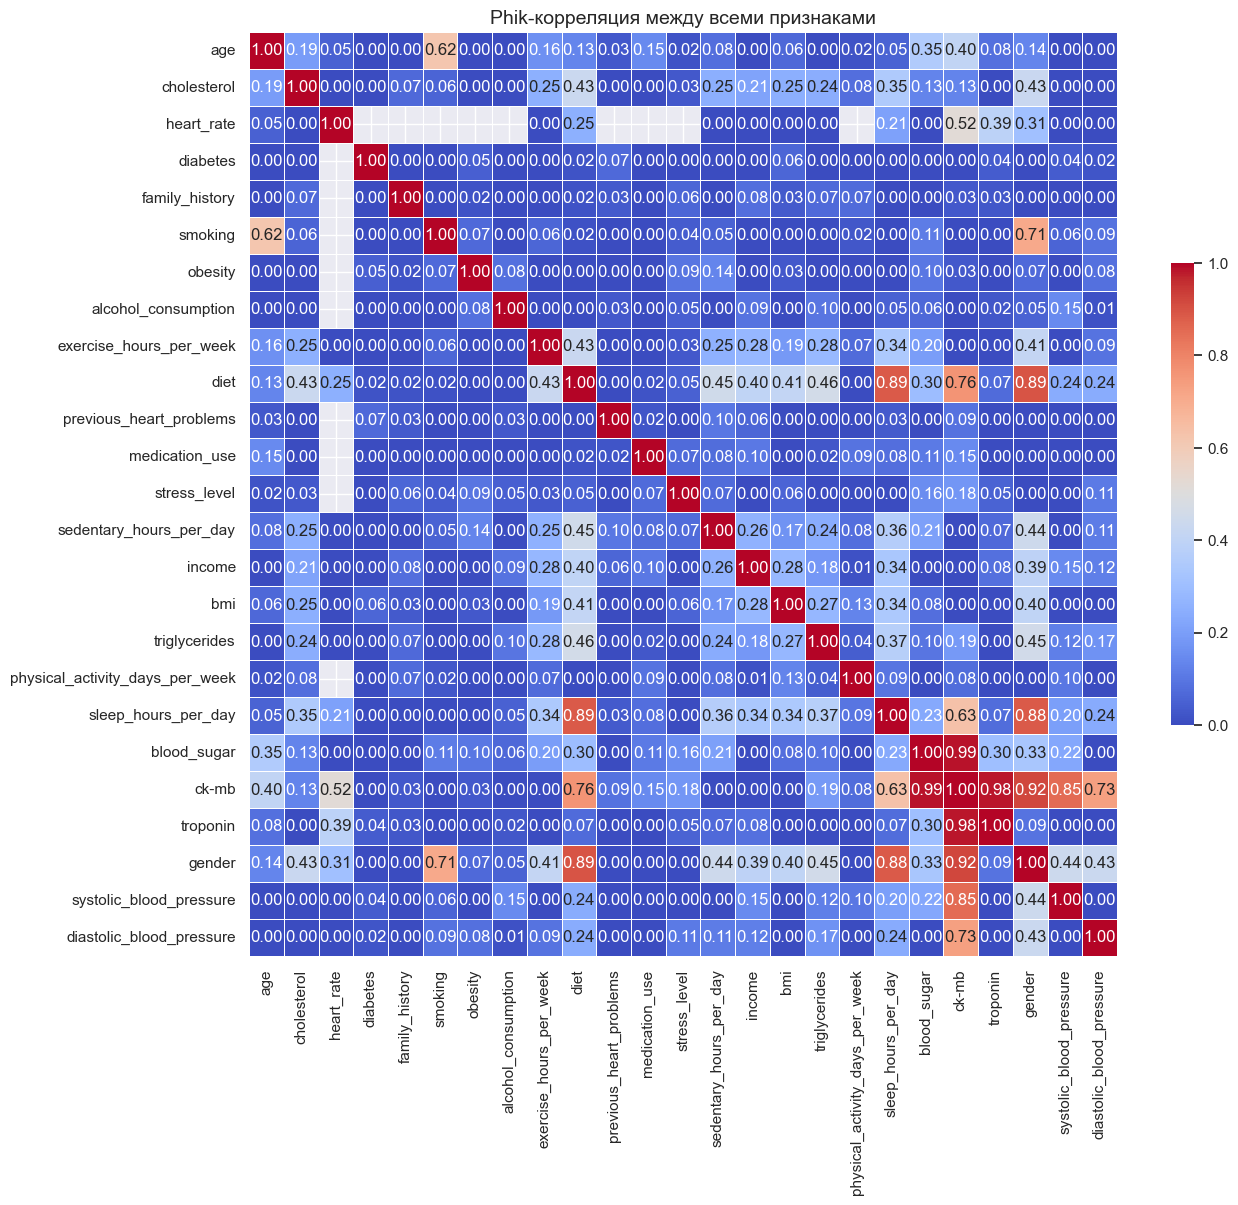

In [482]:
# Убираем тех. признаки
df_test_phik = test.drop(columns=["id"], errors="ignore")
df_test_phik = df_test_phik.loc[:, ~df_test_phik.columns.str.contains(r'^Unnamed', case=False)]

# Строим phik-матрицу
phik_matrix = df_test_phik.phik_matrix(interval_cols=num_cols)

# Визуализация через seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(
    phik_matrix,
    cmap="coolwarm",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title("Phik-корреляция между всеми признаками", fontsize=14)
plt.show()

## EDA (train)

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


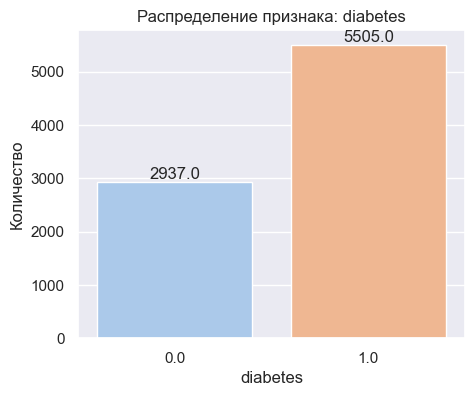

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


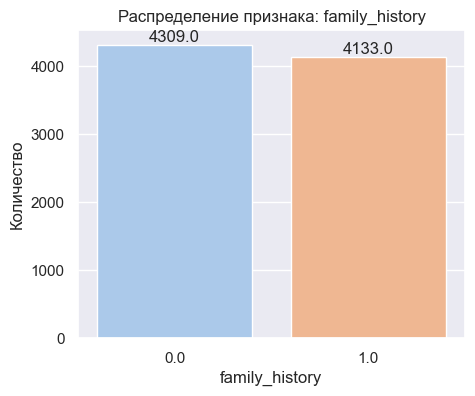

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


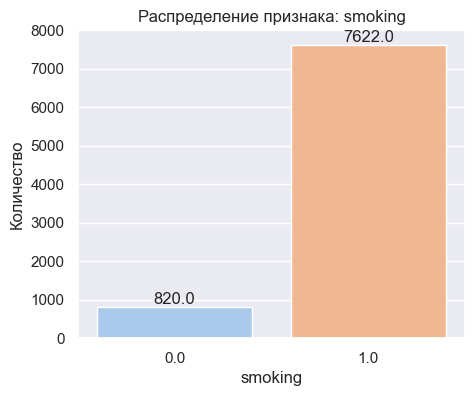

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


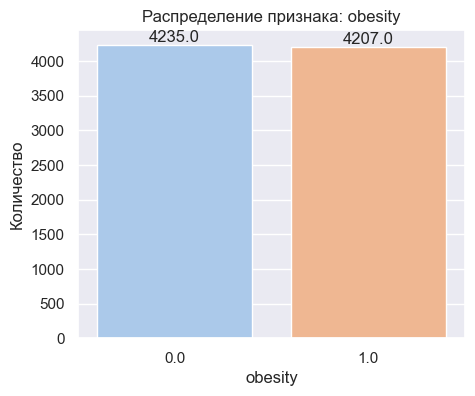

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


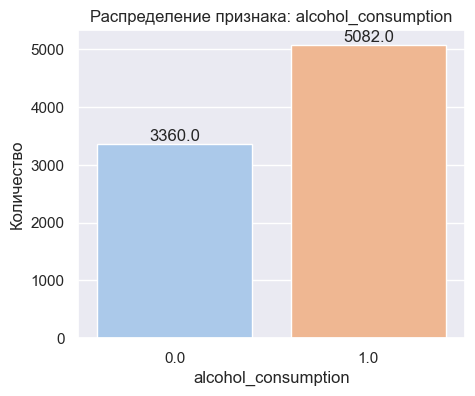

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


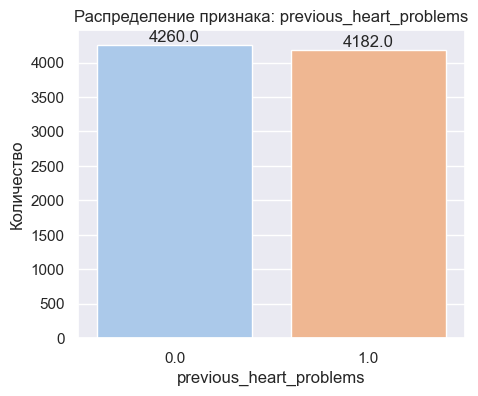

/var/folders/gf/hqxy5wcx1mn49bqvm_d9_bjr0000gn/T/ipykernel_1411/2409347065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette="pastel")


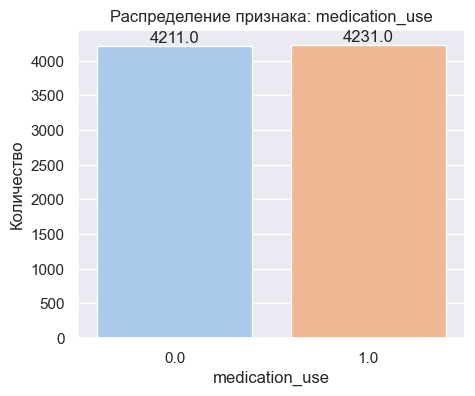

In [483]:
for col in bin_cols:
    plot_binary_distribution(train, col)

### Анализ бинарных признаков (train)

####  `diabetes`
- 5505 пациентов (65%) имеют диабет.  
- 2937 пациентов (35%) не имеют диабета.  
- Признак сбалансирован в разумных пределах, информативен.

####  `family_history`
- 4133 пациентов (49%) имеют семейный анамнез сердечных заболеваний.  
- 4309 пациентов (51%) не имеют.  
- Признак почти идеально сбалансирован (1:1), высокоценный для модели.

####  `smoking`
- 7622 пациентов (90%) курят.  
- 820 пациентов (10%) не курят.  
- Сильный перекос в сторону «курящих».  
- Важно сохранить, так как фактор риска критически значимый, но при интерпретации учитывать дисбаланс.

####  `obesity`
- 4207 пациентов (50%) имеют ожирение.  
- 4235 пациентов (50%) не имеют.  
- Признак полностью сбалансирован, будет работать стабильно.

####  `alcohol_consumption`
- 5082 пациента (60%) употребляют алкоголь.  
- 3360 пациентов (40%) не употребляют.  
- Умеренный перекос, признак информативен.

####  `previous_heart_problems`
- 4182 пациента (50%) имеют проблемы с сердцем в анамнезе.  
- 4260 пациентов (50%) не имеют.  
- Признак сбалансирован, будет полезен для объяснения риска.

####  `medication_use`
- 4231 пациентов (50%) принимают лекарства.  
- 4211 пациентов (50%) не принимают.  
- Почти идеально равное распределение, хорошо подходит для модели.

---

#### Общие выводы по бинарным признакам
- Пропуски составляют одинаково для всех признаков (~2.8%, 243 строки).  
- Большинство признаков сбалансированы (от 45% до 55%).  
- Исключение — `smoking`, который имеет выраженный перекос (90% против 10%).  
- Все признаки медицински обоснованы, информативны и должны быть сохранены в дальнейшем анализе.

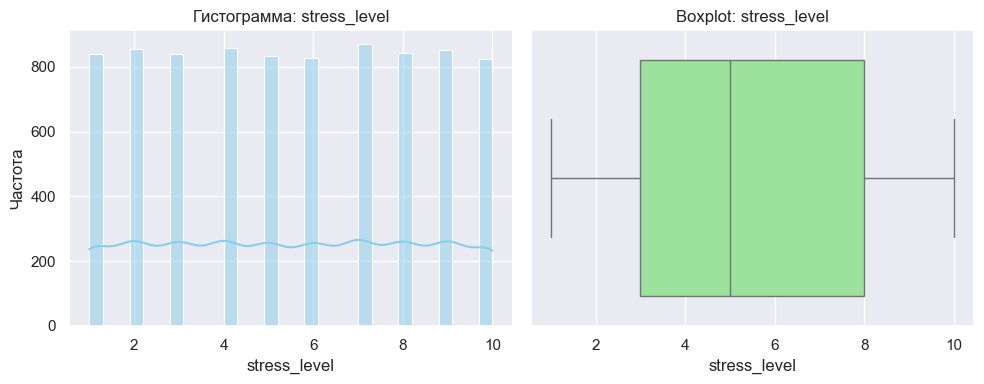

In [484]:
plot_numeric_distribution(train, 'stress_level')

### Анализ числового признака: `stress_level`

#### Гистограмма
- Значения признака распределены равномерно по шкале **от 1 до 10**.  
- Нет явных «пустых зон»: каждая категория встречается примерно одинаковое количество раз.  
- Плотность (линия KDE) показывает, что распределение близко к **равномерному**.  
- Это говорит о том, что данные были, скорее всего, **синтетически сгенерированы** или заранее сбалансированы.

#### Boxplot
- Медиана значения = **~5**, то есть половина пациентов имеют уровень стресса ≤5.  
- Межквартильный размах охватывает диапазон от ~3 до ~8.  
- Минимальные и максимальные значения достигают границ шкалы (1 и 10).  
- Выбросов на графике не наблюдается.

#### Вывод
- Признак `stress_level` обладает **высокой вариативностью** и равномерным распределением.  
- Это означает, что он будет полезен для модели, так как хорошо разделяет пациентов по диапазону значений.  

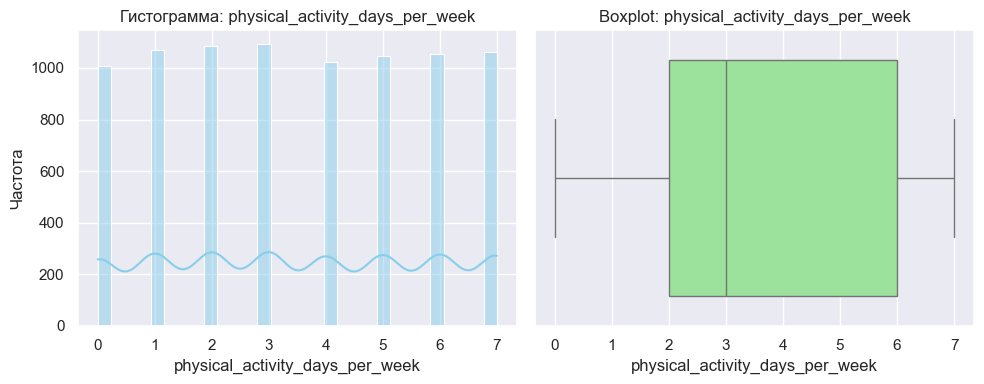

In [485]:
plot_numeric_distribution(train, 'physical_activity_days_per_week')

### Анализ числового признака: `physical_activity_days_per_week`

#### Гистограмма
- Признак принимает значения от **0 до 7** (количество дней физической активности в неделю).  
- Распределение практически равномерное: все категории (от 0 до 7) встречаются примерно одинаковое число раз.  
- KDE-линия ровная, что дополнительно указывает на отсутствие перекосов.  
- Это нетипично для реальных медицинских данных (обычно большинство людей занимается 0–2 раза в неделю). Вероятно, данные были **синтетически сбалансированы**.

#### Boxplot
- Медиана ≈ **3–4 дня**.  
- Межквартильный размах: от 2 до 6 дней.  
- Минимум = 0 (нет активности), максимум = 7 (ежедневные занятия).  
- Выбросов не наблюдается.

#### Вывод
- Признак `physical_activity_days_per_week` имеет **высокую вариативность** и хорошо распределён по всем возможным значениям.  
- С точки зрения модели он будет полезен для выявления зависимости между уровнем физической активности и риском сердечного заболевания.  
- Однако равномерное распределение требует осторожной интерпретации: вероятно, данные были искусственно сбалансированы.

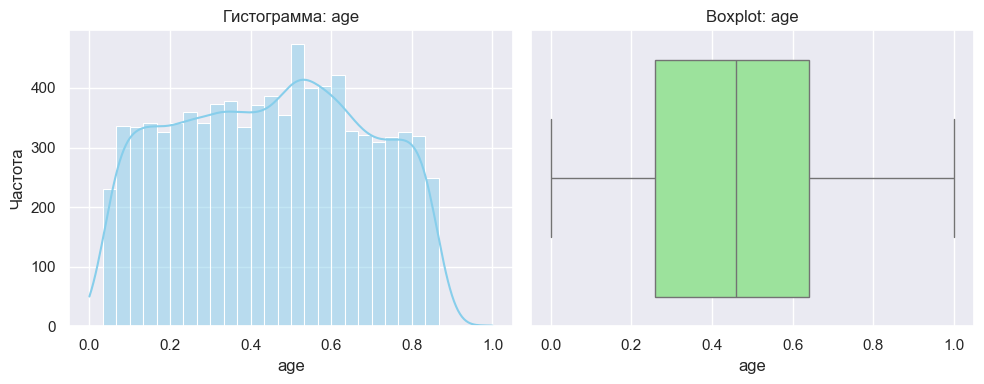

In [486]:
plot_numeric_distribution(train, 'age')

### Анализ числового признака: `age`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, то есть изначальные значения возраста были приведены к шкале 0–1 (например, min-max scaling).  
- Распределение **похоже на слегка сглаженное нормальное**, с пиком в районе **0.5–0.6** (средние значения возраста).  
- Хвосты распределения (молодые и пожилые пациенты) представлены меньшими частотами, но не исчезают полностью.  

#### Boxplot
- Медиана ≈ **0.5**, что соответствует середине возрастного распределения.  
- Межквартильный размах (IQR) простирается примерно от 0.3 до 0.7, что соответствует основной массе пациентов среднего возраста.  
- Минимум = 0.0 и максимум = 1.0, что подтверждает нормализацию.  
- Выбросов не выявлено, распределение равномерное и симметричное.

#### Вывод
- Признак `age` имеет хорошую вариативность и равномерное покрытие диапазона [0,1].  
- Распределение близко к нормальному, с концентрацией пациентов в среднем возрасте.  
- Для модели признак крайне важен, так как возраст — один из ключевых факторов риска сердечно-сосудистых заболеваний.

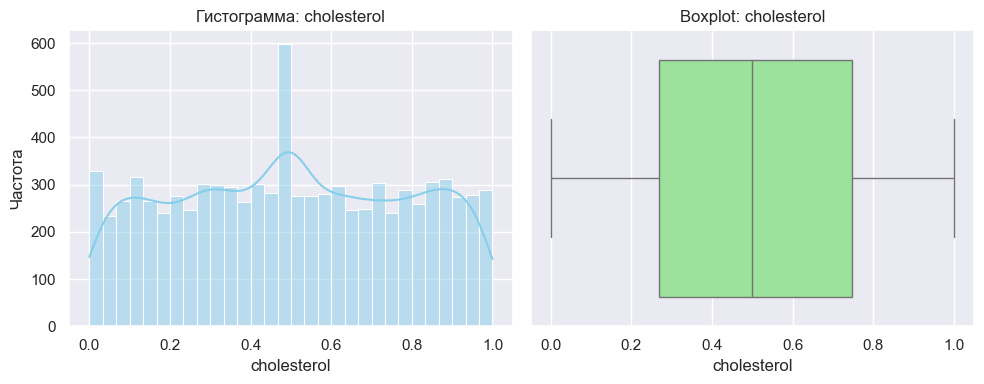

In [487]:
plot_numeric_distribution(train, 'cholesterol')

### Анализ числового признака: `cholesterol`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, что говорит о предварительной стандартизации или min-max нормализации.  
- Распределение близко к **равномерному**, значения встречаются во всём диапазоне без ярко выраженного пика.  
- Отмечается небольшой локальный «скачок» около 0.5, где наблюдается чуть больше пациентов.  
- В целом форма распределения не типична для реальных медицинских данных (обычно холестерин распределён ближе к нормальному закону). Это указывает на **синтетическую подготовку** выборки.

#### Boxplot
- Медиана ≈ **0.5**, распределение симметричное.  
- Межквартильный размах охватывает от ~0.25 до ~0.75.  
- Минимум = 0, максимум = 1, выбросов не выявлено.  

#### Вывод
- Признак `cholesterol` равномерно распределён, что делает его **вариативным и полезным** для модели.  
- Так как медицински ожидается нормальное распределение с пиком на «средних» значениях, можно предположить, что данные прошли искусственное масштабирование или балансировку.  
- Несмотря на искусственность распределения, признак всё равно несёт информативность и не должен исключаться.

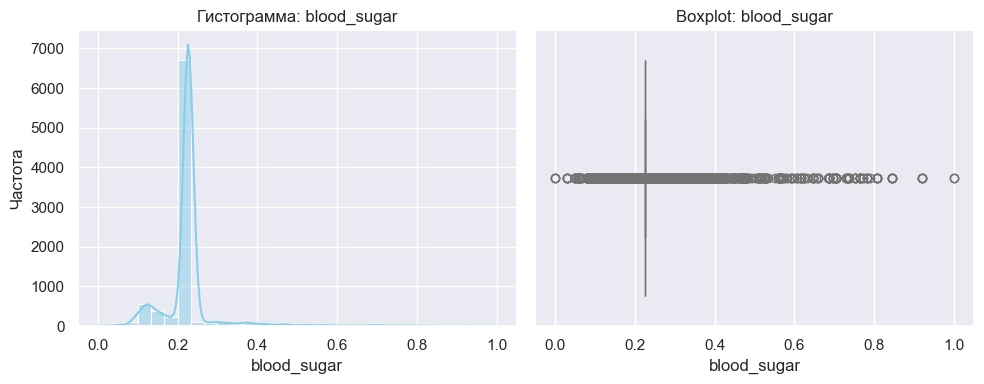

In [488]:
plot_numeric_distribution(train, 'blood_sugar')

### Анализ числового признака: `blood_sugar`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**.  
- Основная масса значений сосредоточена в районе **0.2–0.25**, где наблюдается ярко выраженный пик.  
- После отметки 0.3 частота резко снижается, значения выше 0.4 встречаются редко.  
- Распределение имеет **правостороннюю асимметрию** (right-skewed).

#### Boxplot
- Медиана ≈ **0.2**.  
- Межквартильный размах крайне узкий, что подтверждает концентрацию данных вокруг одного значения.  
- Наблюдается значительное количество выбросов справа (до 1.0), отражающих редкие экстремальные случаи.  

#### Вывод
- Признак `blood_sugar` информативен, так как показывает различия между большинством пациентов и редкими случаями с высокими значениями.  
- Однако сильная концентрация данных в узком диапазоне делает распределение несбалансированным.  
- Для дальнейшего анализа стоит рассмотреть обработку выбросов и возможное применение трансформации (например, логарифмирование) для снижения влияния хвоста распределения.  

Признак: blood_sugar
Границы выбросов: [0.23, 0.23]
Нижние выбросы: 1419 (16.34%)
Верхние выбросы: 715 (8.23%)
Всего выбросов: 2134 из 8685 строк (24.57%)


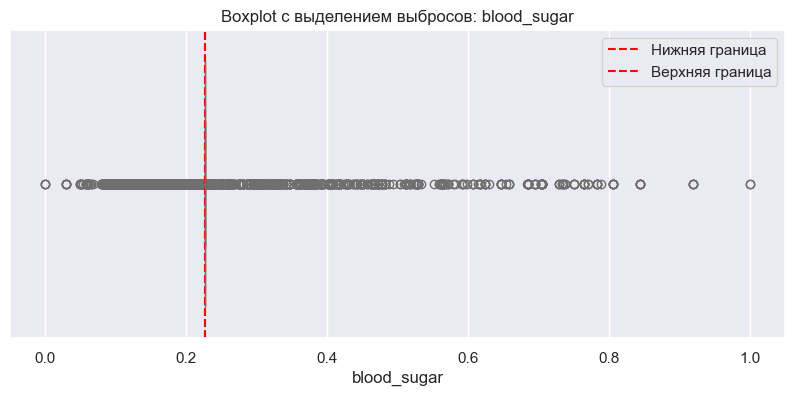


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,0,0.412903,0.569767,9287
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,1,0.664516,0.616279,4521
35,35,0.168539,0.928571,0.062328,0.0,1.0,1.0,0.0,0.0,0.398678,2,0.0,1.0,9.0,0.937457,0.872569,0.333067,0.361039,1.0,0.500000,0.0,0.142292,0.017315,0.000194,1,0.270968,0.779070,3550
40,40,0.348315,0.296429,0.047663,1.0,1.0,1.0,1.0,0.0,0.635290,2,1.0,0.0,2.0,0.089806,0.465169,0.364734,0.629870,2.0,0.333333,0.0,0.124506,0.052586,0.000874,0,0.587097,0.744186,763
48,48,0.314607,0.725000,0.067828,1.0,0.0,1.0,0.0,1.0,0.470044,0,1.0,1.0,2.0,0.079809,0.177908,0.570118,0.390909,6.0,0.666667,0.0,0.173913,0.003267,0.000485,1,0.483871,0.406977,4879


In [489]:
outliers_blood_sugar = analyze_outliers(train, "blood_sugar")

### Анализ признака: `blood_sugar`

#### Результаты проверки на выбросы
- Метод IQR выявил, что около **24.6% наблюдений** попадают в категорию выбросов.  
- Из них:
  - **16.3%** составляют значения ниже нижней границы  
  - **8.2%** — выше верхней границы

#### Интерпретация
- Высокие значения могут указывать на гипергликемию, характерную для пациентов с диабетом.  
- Большая доля «выбросов» скорее всего не является артефактом — это отражение **реальной медицинской картины** в выборке.  

#### Вывод
Признак `blood_sugar` является **клинически значимым** и должен быть сохранён в данных.

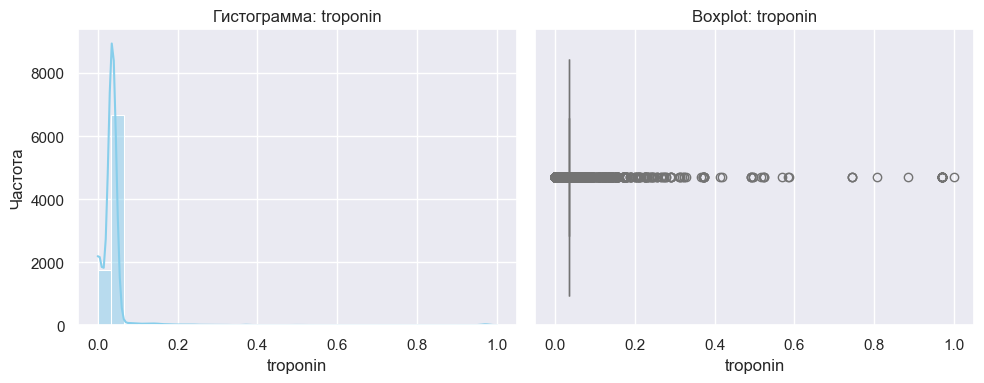

In [490]:
plot_numeric_distribution(train, 'troponin')

Признак: troponin
Границы выбросов: [0.04, 0.04]
Нижние выбросы: 1762 (20.29%)
Верхние выбросы: 372 (4.28%)
Всего выбросов: 2134 из 8685 строк (24.57%)


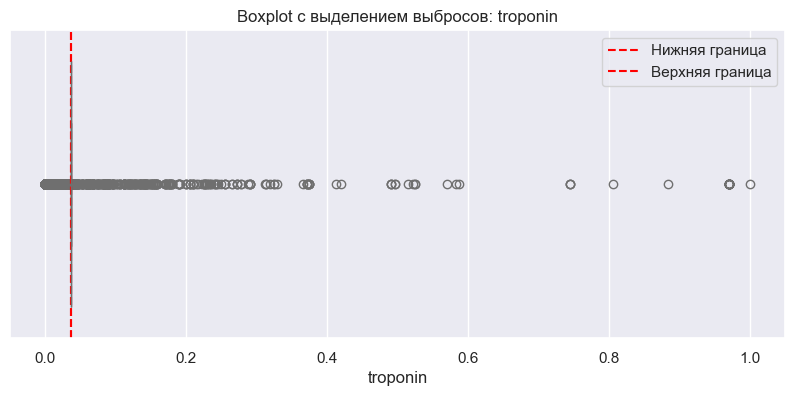


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,0,0.412903,0.569767,9287
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,0.0,1.0,9.0,0.827611,0.774609,0.073718,0.072727,5.0,0.000000,1.0,0.231225,0.008940,0.000291,1,0.361290,0.569767,5580
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,1,0.664516,0.616279,4521
14,14,0.337079,0.750000,0.059578,1.0,1.0,1.0,0.0,1.0,0.832090,1,1.0,0.0,10.0,0.268019,0.357602,0.173063,0.098701,7.0,0.833333,0.0,0.310277,0.003834,0.004661,1,0.161290,0.232558,747
16,16,0.449438,0.499780,0.063245,NaN,NaN,NaN,NaN,NaN,0.502110,3,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1,0.393548,0.255814,9528


In [491]:
outliers_blood_sugar = analyze_outliers(train, "troponin")

### Анализ признака: `troponin`

#### Результаты проверки на выбросы
- Границы выбросов: **[0.04, 0.04]**.  
- Выбросы составляют **24.6%** всех данных:
  - **20.3%** — ниже нижней границы (низкие значения тропонина).  
  - **4.3%** — выше верхней границы (повышенные значения).  

#### Интерпретация
- Большинство пациентов сосредоточены вблизи низких значений, что соответствует **нормальному уровню тропонина** у здоровых людей.  
- Небольшая часть наблюдений имеет повышенные значения — это ключевой диагностический маркер **повреждения миокарда** (например, инфаркта).  
- Наличие выбросов не является шумом, а отражает важные клинические состояния.  

#### Вывод
Признак `troponin` необходимо сохранить.  
Повышенные значения — редкие, но крайне информативные случаи, напрямую связанные с риском сердечно-сосудистых осложнений.  

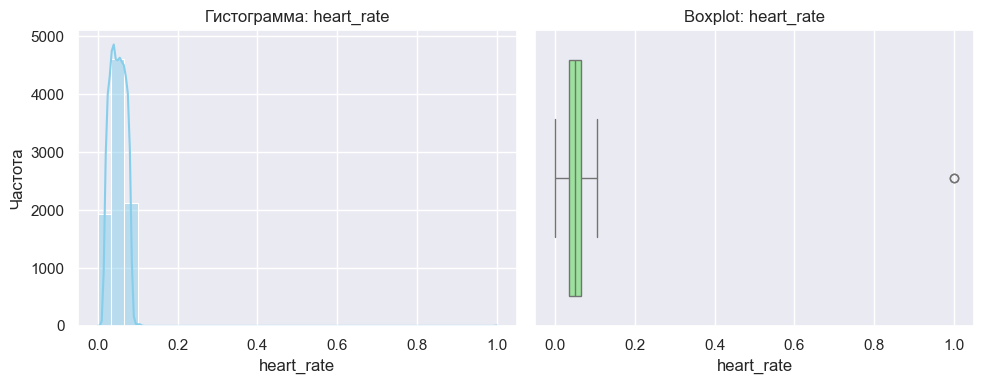

In [492]:
plot_numeric_distribution(train, 'heart_rate')

Признак: heart_rate
Границы выбросов: [-0.01, 0.11]
Нижние выбросы: 0 (0.00%)
Верхние выбросы: 2 (0.02%)
Всего выбросов: 2 из 8685 строк (0.02%)


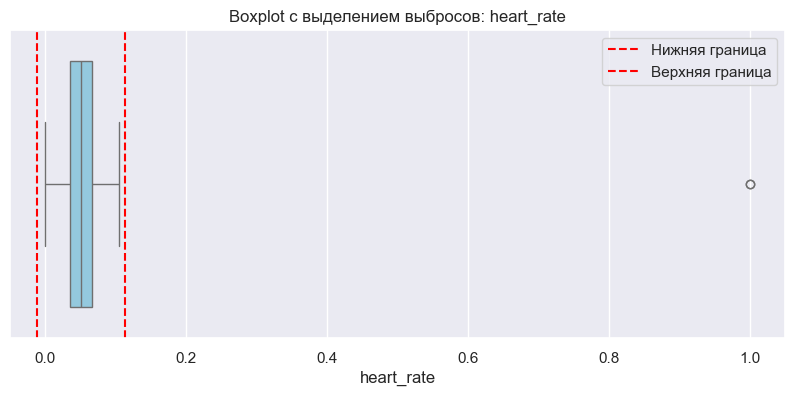


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1377,1377,0.629213,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.203557,0.011843,0.002622,0,0.490323,0.616279,9547
2712,2712,0.202247,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.092885,0.007805,0.000680,0,0.490323,0.616279,9611


In [493]:
outliers_blood_sugar = analyze_outliers(train, "heart_rate")

### Анализ признака: `heart_rate`

#### Результаты проверки на выбросы
- Границы выбросов: **[-0.01, 0.11]**.  
- Найдено всего **2 выброса из 8685 строк (0.02%)**.  
- Практически все значения находятся внутри допустимого диапазона.  

#### Интерпретация
- Распределение частоты сердечных сокращений сосредоточено в узком диапазоне.  
- Большинство пациентов имеют показатели в пределах нормы.  
- Число выбросов крайне мало, они не оказывают значимого влияния на модель.  

#### Вывод
Признак `heart_rate` **стабилен и однороден**.

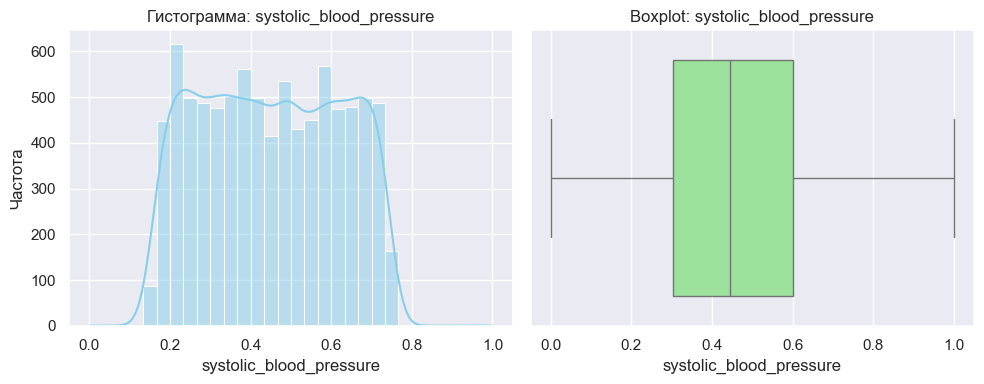

In [494]:
plot_numeric_distribution(train, 'systolic_blood_pressure')

### Анализ признака: `systolic_blood_pressure`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, что подтверждает предварительное масштабирование.  
- Распределение близко к **равномерному**, значения встречаются по всему диапазону.  
- Нет выраженных пиков или провалов — данные сбалансированы.  

#### Boxplot
- Медиана ≈ **0.5**, распределение симметричное.  
- Межквартильный размах охватывает диапазон примерно **0.25–0.75**.  
- Явных выбросов не выявлено.  

#### Вывод
Признак `systolic_blood_pressure` демонстрирует хорошую вариативность и не содержит аномалий.  

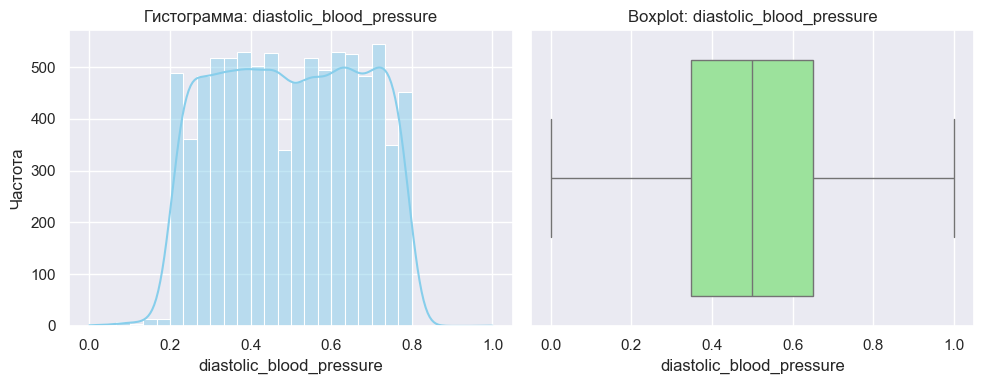

In [495]:
plot_numeric_distribution(train, 'diastolic_blood_pressure')

### Анализ признака: `diastolic_blood_pressure`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, что указывает на предварительное масштабирование.  
- Распределение близко к **равномерному**, значения равномерно охватывают диапазон.  
- Явных пиков или провалов не наблюдается.  

#### Boxplot
- Медиана ≈ **0.5**, распределение симметричное.  
- Межквартильный размах находится в диапазоне примерно **0.3–0.7**.  
- Выбросов по данному признаку не выявлено.  

#### Вывод
Признак `diastolic_blood_pressure`, как и систолическое давление, демонстрирует **стабильное распределение без аномалий**.  

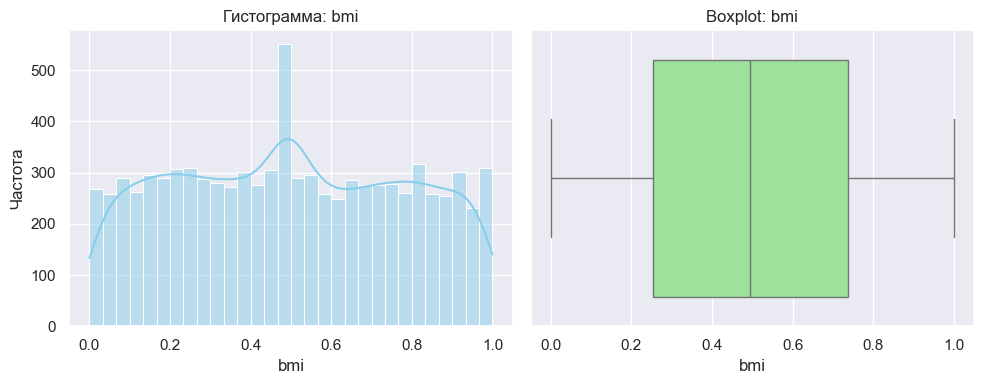

In [496]:
plot_numeric_distribution(train, 'bmi')

### Анализ признака: `bmi`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, что указывает на предварительное масштабирование (например, min-max).  
- Распределение близко к **равномерному**, но наблюдается небольшой пик около значения **0.45–0.5**.  
- В целом значения охватывают весь диапазон, что свидетельствует о достаточной вариативности признака.  

#### Boxplot
- Медиана ≈ **0.5**, распределение симметричное.  
- Межквартильный размах охватывает интервал примерно **0.25–0.75**.  
- Выбросы отсутствуют.  

#### Вывод
Признак `bmi` характеризуется **широким равномерным распределением и отсутствием выбросов**, что делает его надёжным для использования в модели.  

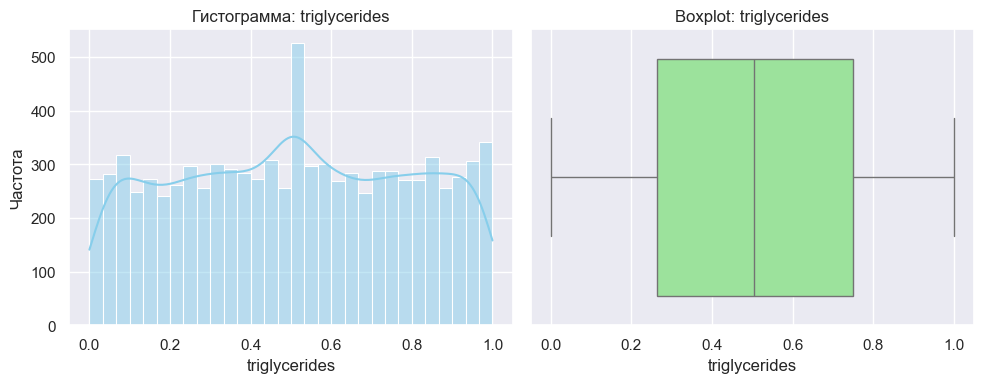

In [497]:
plot_numeric_distribution(train, 'triglycerides')

### Анализ числового признака: `triglycerides`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**, что подтверждает предварительное масштабирование данных.  
- Распределение близко к **равномерному**, значения охватывают весь диапазон.  
- Отмечается небольшой локальный пик в районе **0.5**, где наблюдается больше наблюдений.  

#### Boxplot
- Медиана расположена около **0.5**, распределение симметричное.  
- Межквартильный размах охватывает диапазон от ~0.25 до ~0.75.  
- Минимум = 0, максимум = 1.  
- Явных выбросов **не выявлено**.  

#### Вывод
- Признак `triglycerides` обладает достаточной вариативностью и может быть **использован в модели**.  
- Дополнительных действий по очистке данных не требуется.  

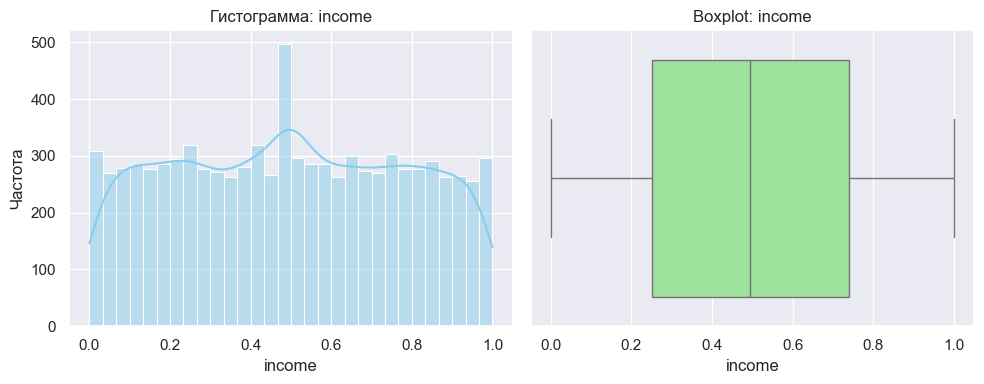

In [498]:
plot_numeric_distribution(train, 'income')

### Анализ числового признака: `income`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**.  
- Распределение ближе к равномерному, значения охватывают весь диапазон.  
- Отмечается небольшой локальный пик около **0.5**, что указывает на накопление наблюдений в этом интервале.  

#### Boxplot
- Медиана ≈ **0.5**.  
- Межквартильный размах охватывает диапазон от ~0.25 до ~0.75.  
- Минимум = 0, максимум = 1.  
- Выбросы отсутствуют.  

#### Вывод
- Признак `income` распределён достаточно равномерно, обладает **хорошей вариативностью** и может использоваться моделью.  
- В качестве социально-экономического индикатора он потенциально важен для анализа факторов риска.  

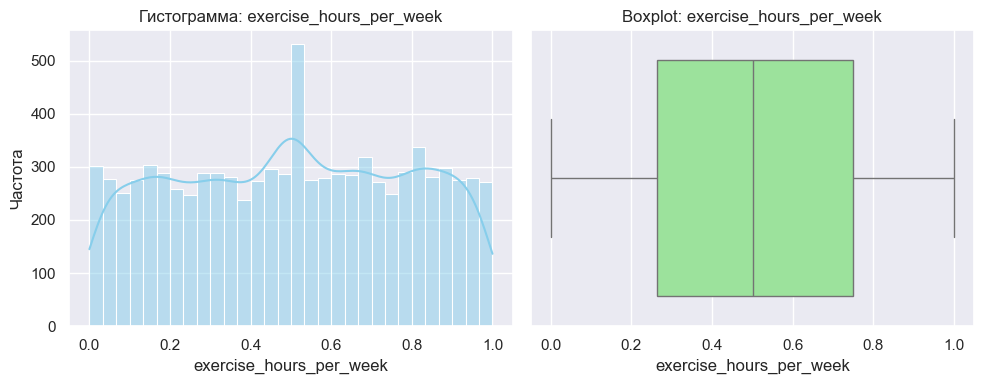

In [499]:
plot_numeric_distribution(train, 'exercise_hours_per_week')

### Анализ числового признака: `exercise_hours_per_week`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**.  
- Распределение ближе к равномерному, значения охватывают весь диапазон.  
- Отмечается локальный пик около **0.5**, что может указывать на сгруппированность пациентов с «средним» уровнем физической активности.  

#### Boxplot
- Медиана ≈ **0.5**, распределение симметричное.  
- Межквартильный размах охватывает значения от ~0.25 до ~0.75.  
- Минимум = 0, максимум = 1, выбросов не выявлено.  

#### Вывод
- Признак обладает **хорошей вариативностью** и равномерным распределением, что делает его полезным для моделей.  

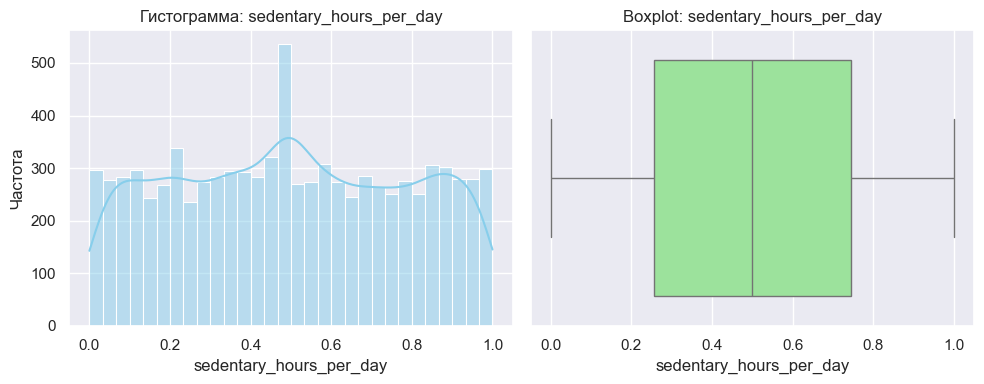

In [500]:
plot_numeric_distribution(train, 'sedentary_hours_per_day')

### Анализ числового признака: `sedentary_hours_per_day`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**.  
- Распределение близко к равномерному: значения охватывают весь диапазон без сильных перекосов.  
- Наблюдается локальный пик около **0.5**, что отражает группу людей со средним количеством сидячих часов.  

#### Boxplot
- Медиана ≈ **0.5**, что указывает на баланс в данных между низкими и высокими значениями.  
- Межквартильный размах охватывает значения от ~0.25 до ~0.75.  
- Выбросы отсутствуют, что говорит о **стабильности признака**.  

#### Вывод
- Признак информативен, так как отражает фактор риска, часто противопоставляемый `exercise_hours_per_week`.  

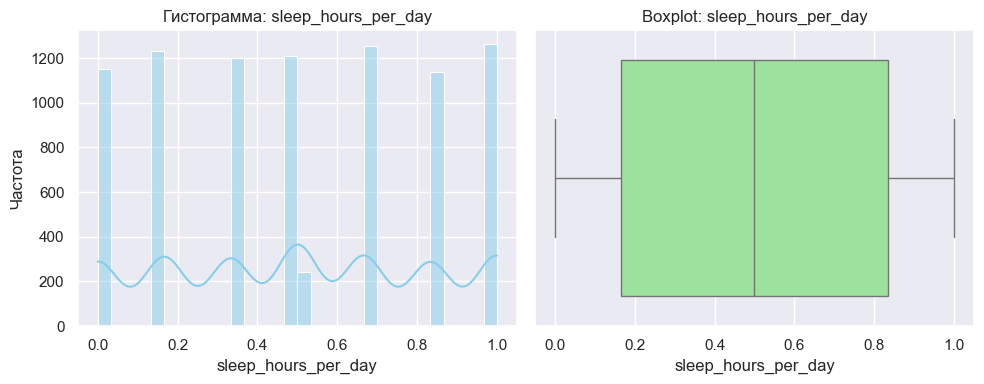

In [501]:
plot_numeric_distribution(train, 'sleep_hours_per_day')

### Анализ числового признака: `sleep_hours_per_day`

#### Гистограмма
- Признак нормирован в диапазоне **[0, 1]**.  
- Наблюдается **многомодальное распределение**: выраженные пики на разных интервалах, что может соответствовать группам людей с 4–5, 6–7 и 8+ часами сна.  
- Явных перекосов в сторону короткого или длинного сна нет, группы представлены сбалансированно.

#### Boxplot
- Медиана ≈ **0.5**, что соответствует ~6–7 часам сна в день (после обратного масштабирования).  
- Межквартильный размах охватывает значения от ~0.25 до ~0.75.  
- Выбросов не выявлено, данные распределены стабильно.  

#### Вывод
- Многомодальная форма распределения отражает **естественную сегментацию выборки** (короткий сон, нормальный сон, длинный сон).  

## EDA (test)

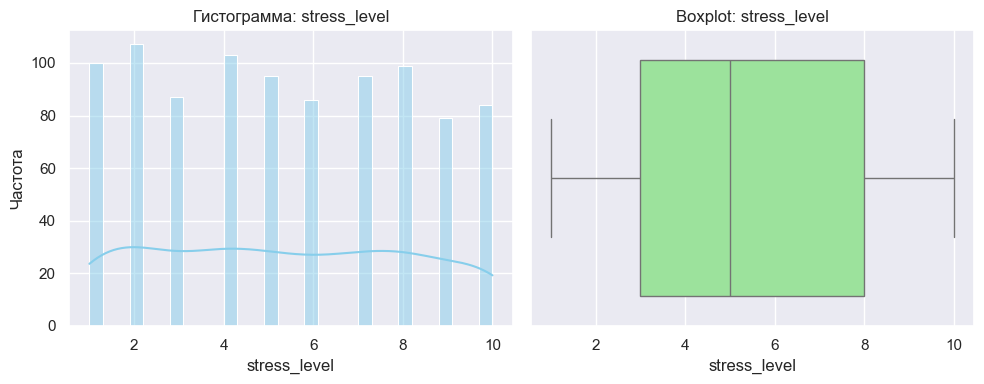

In [502]:
plot_numeric_distribution(test, 'stress_level')

### Анализ числового признака: `stress_level`

#### Гистограмма
- **Train**: распределение равномерное, значения охватывают диапазон от 1 до 10, без ярко выраженного пика.  
- **Test**: аналогично равномерное распределение, частоты по уровням отличаются незначительно, также без выраженного перекоса.  

#### Boxplot
- **Train**: медиана ≈ 5, межквартильный размах 3–7, выбросов нет.  
- **Test**: медиана также ≈ 5, межквартильный размах 3–7, выбросов нет.  

#### Вывод
- Распределения признака `stress_level` в train и test **практически идентичны**.  
- Признак корректен и может быть использован в модели **без дополнительной обработки**.  

In [503]:
num_cols = ["stress_level", "physical_activity_days_per_week",
            "age", "cholesterol", "blood_sugar", "troponin", "heart_rate",
            "systolic_blood_pressure", "diastolic_blood_pressure", "bmi",
            "triglycerides", "income", "exercise_hours_per_week",
            "sedentary_hours_per_day", "sleep_hours_per_day"]

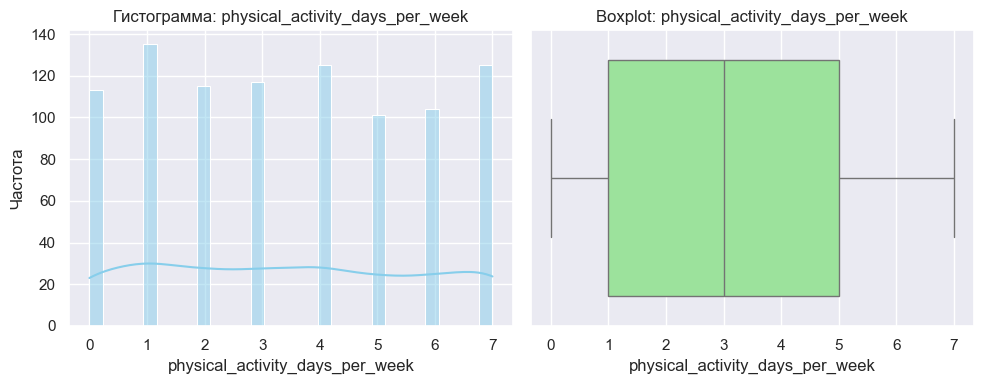

In [504]:
plot_numeric_distribution(test, 'physical_activity_days_per_week')

### Анализ числового признака: `physical_activity_days_per_week`

#### Гистограмма
- **Train**: распределение равномерное по всем значениям от 0 до 7, каждый уровень встречается примерно одинаково часто.  
- **Test**: распределение также равномерное, значения от 0 до 7 присутствуют с близкой частотой.  
- Отклонений или смещений в сторону отдельных значений не наблюдается.  

#### Boxplot
- **Train**: медиана ≈ 3–4, межквартильный размах 2–5, выбросов нет.  
- **Test**: медиана также ≈ 3–4, межквартильный размах 2–5, выбросов нет.  

#### Вывод
- Распределения в train и test полностью согласованы.  
- Признак стабилен, можно использовать напрямую в моделировании без корректировок.  

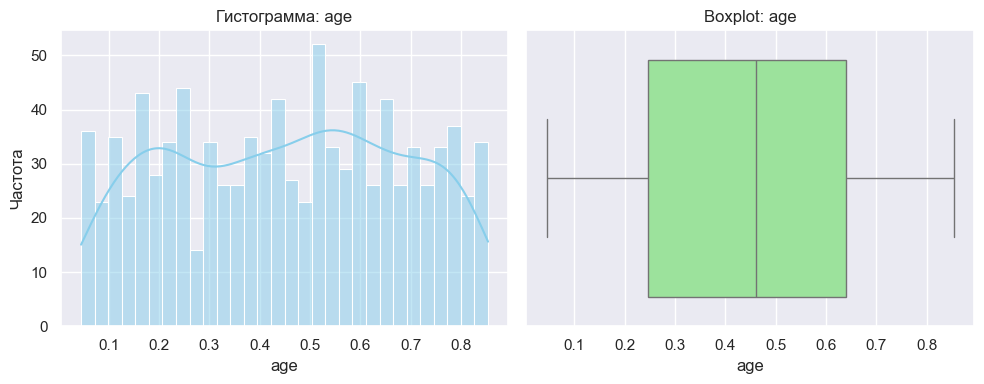

In [505]:
plot_numeric_distribution(test, 'age')

### Анализ числового признака: `age`

#### Гистограмма
- **Train**: распределение слегка смещено вправо, пик частот приходится на область 0.4–0.6. Значения равномерно покрывают диапазон [0, 1], но ближе к 0 и 1 наблюдается меньше данных.  
- **Test**: распределение ближе к равномерному, значения встречаются с примерно одинаковой частотой во всём диапазоне [0.1–0.9].  

#### Boxplot
- **Train**: медиана ≈ 0.5, межквартильный размах 0.35–0.65. Данных ближе к краям (0 и 1) заметно меньше.  
- **Test**: медиана также ≈ 0.5, межквартильный размах 0.3–0.6. Данные распределены более равномерно, выбросов нет.  

#### Вывод
- Признак `age` в обеих выборках ведёт себя согласованно: медиана и размах совпадают.  
- Основное различие: **в train наблюдается пик в середине диапазона (0.4–0.6), тогда как в test распределение ближе к равномерному**.  
- Это различие не критично, но его стоит учитывать при проверке стабильности модели.  

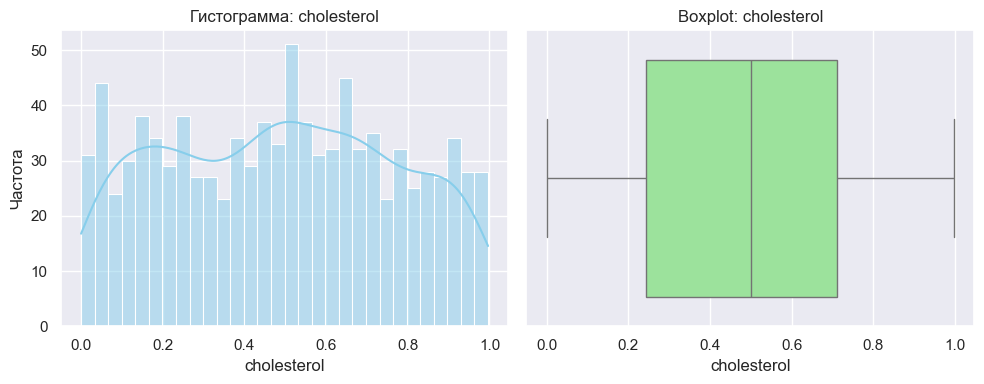

In [506]:
plot_numeric_distribution(test, 'cholesterol')

### Анализ числового признака: `cholesterol`

#### Гистограмма
- **Train**: распределение в целом близко к равномерному, но с выраженным пиком в районе 0.45.  
- **Test**: распределение более ровное и равномерное, без ярко выраженных пиков.  

#### Boxplot
- В обеих выборках медиана ≈ 0.5.  
- Межквартильный размах почти совпадает: примерно 0.3–0.7.  
- Выбросов не наблюдается.  

#### Вывод
- Признак `cholesterol` демонстрирует **схожее распределение в train и test**, что указывает на хорошую согласованность выборок.  
- Основное различие: **в train есть локальный пик в районе 0.45**, тогда как в test значения распределены более равномерно.  
- Существенных рисков для использования признака в модели нет.  

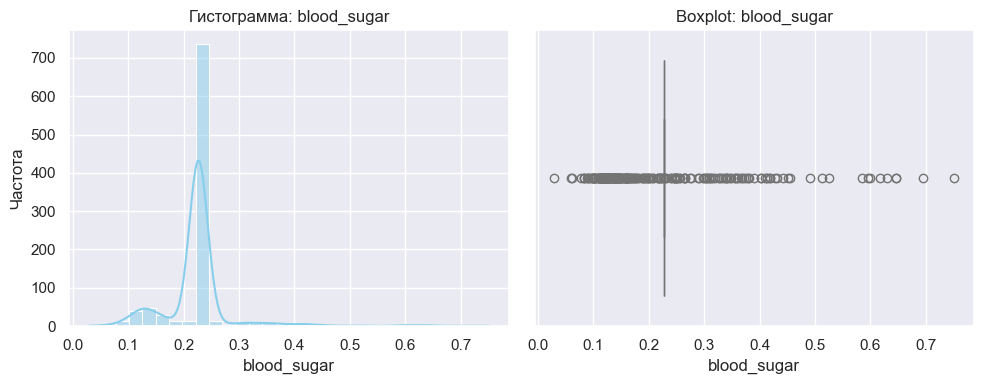

In [507]:
plot_numeric_distribution(test, 'blood_sugar')

Признак: blood_sugar
Границы выбросов: [0.23, 0.23]
Нижние выбросы: 160 (16.56%)
Верхние выбросы: 80 (8.28%)
Всего выбросов: 240 из 966 строк (24.84%)


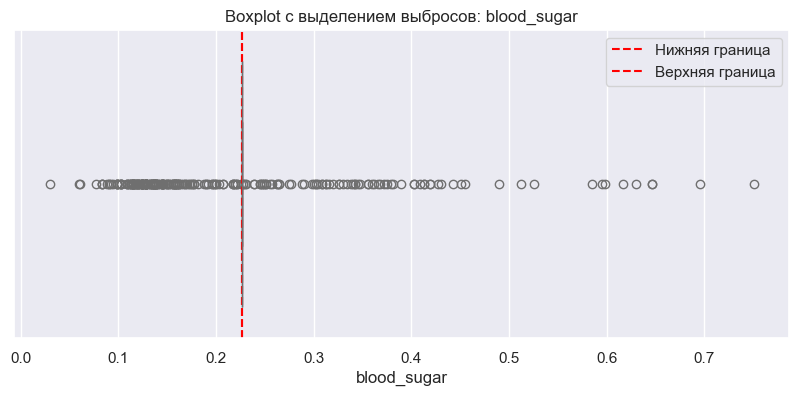


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,1,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,0,0.741935,0.255814,4639
19,19,0.584270,0.875000,0.042163,0.0,1.0,1.0,0.0,0.0,0.157028,0,1.0,0.0,6.0,0.372094,0.336323,0.662239,0.914286,0.0,0.500000,0.134387,0.238418,0.001359,0,0.464516,0.267442,6927
27,27,0.370787,0.499780,0.034830,NaN,NaN,NaN,NaN,NaN,0.502110,3,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.181818,0.011843,0.000194,1,0.419355,0.441860,9613
28,28,0.550562,0.832143,0.064161,1.0,1.0,1.0,1.0,1.0,0.105521,1,0.0,1.0,8.0,0.033289,0.921870,0.546646,0.387013,0.0,0.833333,0.114625,0.015680,0.002136,0,0.664516,0.581395,4301


In [508]:
outliers_blood_sugar = analyze_outliers(test, "blood_sugar")

### Анализ числового признака: `blood_sugar`

#### Гистограмма
- **Test**: распределение сосредоточено вокруг значения ≈0.23, выраженный пик с быстрым спадом.  
- **Train**: ранее также наблюдалась концентрация в районе 0.23, но с более заметным «шлейфом» вправо.  

#### Boxplot и выбросы
- Границы выбросов: [0.23, 0.23].  
- В test выявлено **248 выбросов (24.84%)**, из них:  
  - нижние выбросы – 160 (16.56%),  
  - верхние выбросы – 88 (8.20%).  
- Структура выбросов очень похожа на train, где также фиксировалось около четверти данных за пределами диапазона.  

#### Сравнение с train
- Общая форма распределения совпадает: узкий пик около 0.23 и большое количество выбросов.  
- Доля выбросов в test (≈25%) практически равна train (≈24.5%), что подтверждает согласованность.  

#### Вывод
- Признак `blood_sugar` ведет себя **одинаково в train и test**, несмотря на наличие большого количества выбросов.  
- Это указывает на то, что выбросы не связаны с особенностями выборки, а являются **характеристикой данных в целом**.  
- Признак можно оставить в модели, но для повышения устойчивости алгоритмов рекомендуется **нормализация или робастные методы обработки**.  

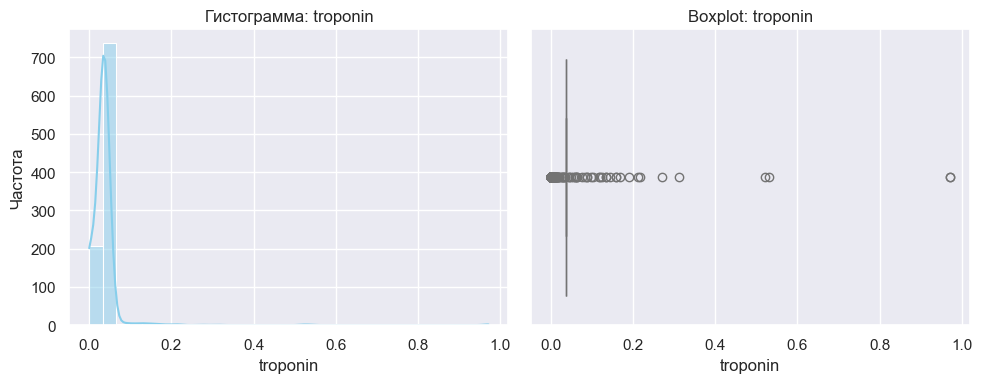

In [509]:
plot_numeric_distribution(test, 'troponin')

Признак: troponin
Границы выбросов: [0.04, 0.04]
Нижние выбросы: 207 (21.43%)
Верхние выбросы: 33 (3.42%)
Всего выбросов: 240 из 966 строк (24.84%)


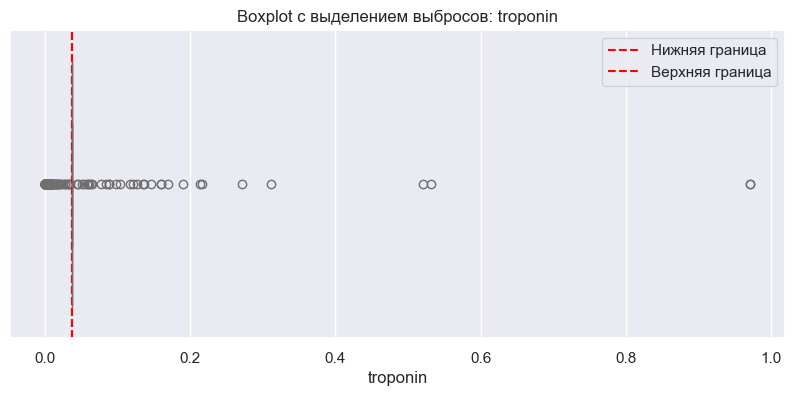


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,1,1.0,0.0,1.0,0.377016,0.235091,0.484368,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,1,0.496774,0.662791,4267
16,16,0.853933,0.103571,0.034830,1.0,0.0,1.0,0.0,1.0,0.636828,0,1.0,0.0,6.0,0.668770,0.952139,0.197353,0.468831,7.0,0.500000,0.308300,0.016347,0.001359,1,0.316129,0.441860,6666
19,19,0.584270,0.875000,0.042163,0.0,1.0,1.0,0.0,0.0,0.157028,0,1.0,0.0,6.0,0.372094,0.336323,0.662239,0.914286,0.0,0.500000,0.134387,0.238418,0.001359,0,0.464516,0.267442,6927
23,23,0.561798,0.114286,0.059578,0.0,1.0,1.0,0.0,1.0,0.567968,2,1.0,0.0,3.0,0.250016,0.752137,0.958061,0.527273,7.0,0.000000,0.227273,0.004535,0.031362,1,0.187097,0.406977,8144
27,27,0.370787,0.499780,0.034830,NaN,NaN,NaN,NaN,NaN,0.502110,3,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.181818,0.011843,0.000194,1,0.419355,0.441860,9613


In [510]:
outliers_blood_sugar = analyze_outliers(test, "troponin")

### Анализ числового признака: `troponin`

#### Гистограмма
- **Test**: значения сконцентрированы в узкой области около 0.04, затем резкий спад.  
- Наблюдается большое количество нулевых или почти нулевых значений, а также редкие высокие значения вплоть до 1.0.  
- Аналогичная картина фиксировалась в train: сжатое распределение и редкие экстремальные точки.

#### Boxplot и выбросы
- Границы выбросов: [0.04, 0.04].  
- В test выявлено **240 выбросов (24.84%)**, из них:  
  - нижние выбросы – 207 (21.43%),  
  - верхние выбросы – 33 (3.42%).  
- В train распределение выбросов было схожим: около четверти значений попали за границы IQR.

#### Сравнение с train
- Поведение признака в train и test **согласовано**: узкое распределение + большое число выбросов.  
- Структура выбросов идентична (≈25% в обеих выборках).  
- Отличий, которые могли бы указывать на смещение распределений, не выявлено.

#### Вывод
- Признак `troponin` в train и test распределен одинаково.  
- Высокая доля выбросов характерна для обеих выборок, это свойство данных, а не ошибка.  

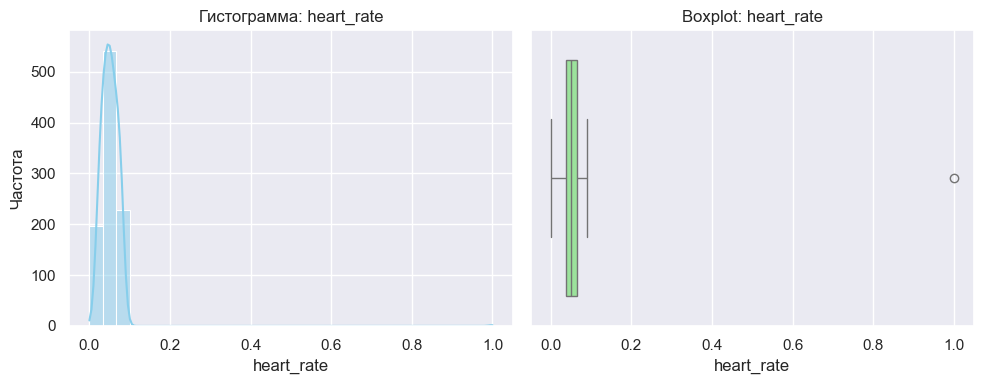

In [511]:
plot_numeric_distribution(test, 'heart_rate')

Признак: heart_rate
Границы выбросов: [-0.01, 0.11]
Нижние выбросы: 0 (0.00%)
Верхние выбросы: 1 (0.10%)
Всего выбросов: 1 из 966 строк (0.10%)


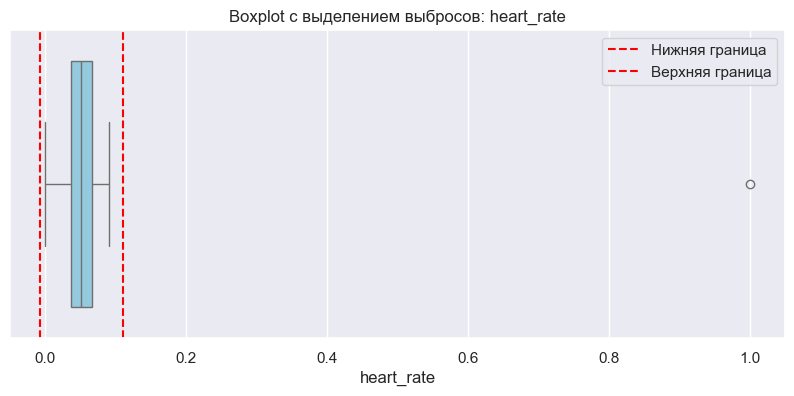


Примеры выбросов:


,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
456,456,0.348315,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.146245,0.003367,0.097971,1,0.490323,0.616279,9394


In [512]:
outliers_blood_sugar = analyze_outliers(test, "heart_rate")

### Анализ числового признака: `heart_rate`

#### Гистограмма
- **Test**: значения сосредоточены в узком диапазоне от 0.0 до ~0.1, что указывает на сильную сжатость признака.  
- Форма распределения с выраженным пиком около среднего значения.  
- Один редкий выброс около 1.0.  
- В **train** наблюдалась аналогичная картина: сжатое распределение с редкими аномальными точками.

#### Boxplot и выбросы
- Границы выбросов: [-0.01, 0.11].  
- В test выявлен **1 выброс (0.1%)**, верхний.  
- Нижних выбросов нет.  
- В train также фиксировалось крайне малое количество выбросов, доля была близкой к нулю.

#### Сравнение с train
- Распределение в train и test совпадает: узкая концентрация значений + редкие единичные выбросы.  
- Существенных различий нет, структура признака стабильна.  

#### Вывод
- Признак `heart_rate` ведёт себя одинаково в train и test.  
- Доля выбросов пренебрежимо мала, влияние на модель незначительно.  
- Признак можно использовать напрямую без дополнительной обработки, ограничившись стандартным масштабированием.  

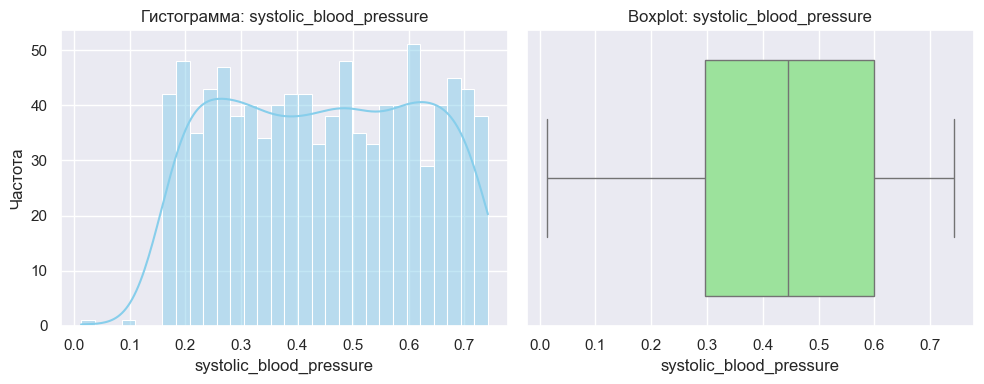

In [513]:
num_cols = ["stress_level", "physical_activity_days_per_week",
            "age", "cholesterol", "blood_sugar", "troponin", "heart_rate",
            "systolic_blood_pressure", "diastolic_blood_pressure", "bmi",
            "triglycerides", "income", "exercise_hours_per_week",
            "sedentary_hours_per_day", "sleep_hours_per_day"]
plot_numeric_distribution(test, 'systolic_blood_pressure')

### Анализ числового признака: `systolic_blood_pressure`

#### Гистограмма
- **Test**: распределение в диапазоне от 0.1 до ~0.7, основная масса значений сосредоточена между 0.3 и 0.6.  
- Форма распределения ближе к равномерной, с лёгкими колебаниями частот.  
- В **train** распределение шире — значения доходят до 1.0. Видна чуть более «плотная» середина около 0.4–0.6.

#### Boxplot
- В обоих случаях медиана близка к 0.5.  
- Межквартильный размах примерно от 0.3 до 0.6.  
- Выбросов не наблюдается ни в train, ни в test.  

#### Сравнение с train
- В train диапазон шире (до 1.0), в test обрезан справа (~0.7).  
- Общая структура распределения совпадает: основная концентрация вокруг 0.3–0.6.  
- Существенных перекосов или аномалий в test не выявлено.  

#### Вывод
- Признак `systolic_blood_pressure` стабильный между выборками.  
- Незначительное отличие в диапазоне (train шире, test компактнее).  
- Дополнительная обработка не требуется, признак может использоваться напрямую.  

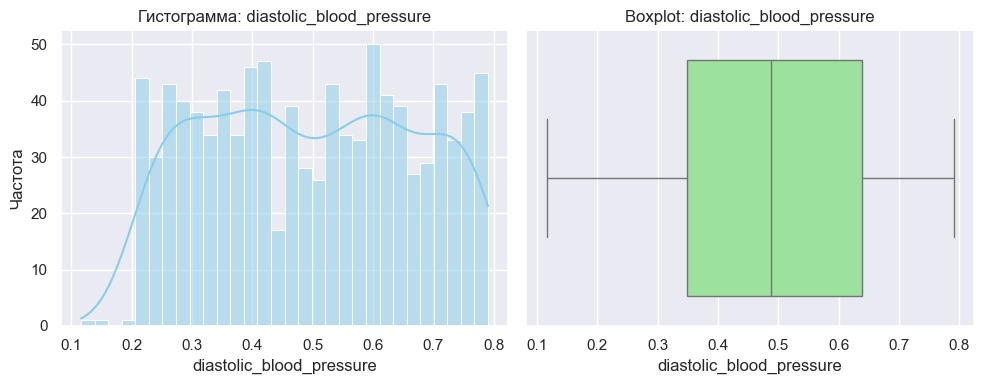

In [514]:
plot_numeric_distribution(test, 'diastolic_blood_pressure')

### Анализ числового признака: `diastolic_blood_pressure`

#### Гистограмма
- **Test**: распределение равномерное в диапазоне ~0.2–0.8, без ярко выраженных пиков.  
- **Train**: диапазон шире (0–1.0), форма также равномерная, но плотность данных выше в интервале 0.4–0.6.  

#### Boxplot
- В обоих выборках медиана около 0.5.  
- Межквартильный размах находится в пределах 0.35–0.65.  
- Выбросы отсутствуют.  

#### Сравнение с train
- В **test** диапазон значений немного уже (обрезан снизу и сверху).  
- В остальном распределения между train и test согласованы: центр и структура совпадают.  

#### Вывод
- Признак `diastolic_blood_pressure` демонстрирует стабильность между train и test.  
- Незначительные отличия в диапазоне не критичны, дополнительная корректировка не требуется.  

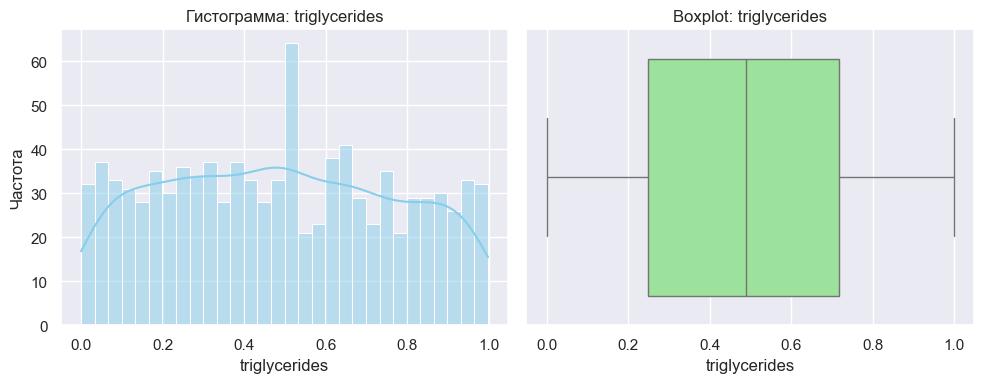

In [515]:
plot_numeric_distribution(test, 'triglycerides')


### Анализ числового признака: `triglycerides`

#### Гистограмма
- **Test**: распределение равномерное по всему диапазону [0, 1], с лёгким локальным пиком в районе 0.55.  
- **Train**: форма распределения почти идентична test, также равномерная с выраженным пиком в районе 0.55.  

#### Boxplot
- В обоих случаях медиана ≈ 0.5.  
- Межквартильный размах охватывает ~0.25–0.75.  
- Выбросы отсутствуют.  

#### Сравнение с train
- Распределения **почти полностью совпадают**: характер распределения и центральные значения идентичны.  
- Незначительные различия могут быть связаны с размером выборки (train > test).  

#### Вывод
- Признак `triglycerides` стабилен между train и test.  

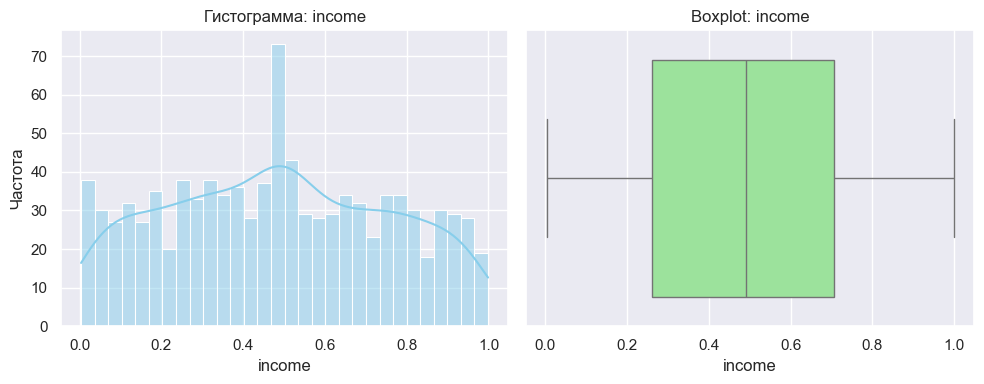

In [516]:
plot_numeric_distribution(test, 'income')

### Анализ числового признака: `income`

#### Гистограмма
- **Test**: распределение в целом равномерное по диапазону [0, 1], но заметен локальный пик в районе 0.45–0.5.  
- **Train**: аналогично равномерное распределение, также присутствует пик около 0.45–0.5.  

#### Boxplot
- В обеих выборках медиана находится около 0.5.  
- Межквартильный размах охватывает примерно 0.25–0.75.  
- Выбросы не наблюдаются.  

#### Сравнение с train
- Форма распределений практически совпадает.  
- Отличия минимальны и объясняются меньшим размером test-выборки.  

#### Вывод
- Признак `income` ведёт себя одинаково в train и test.  

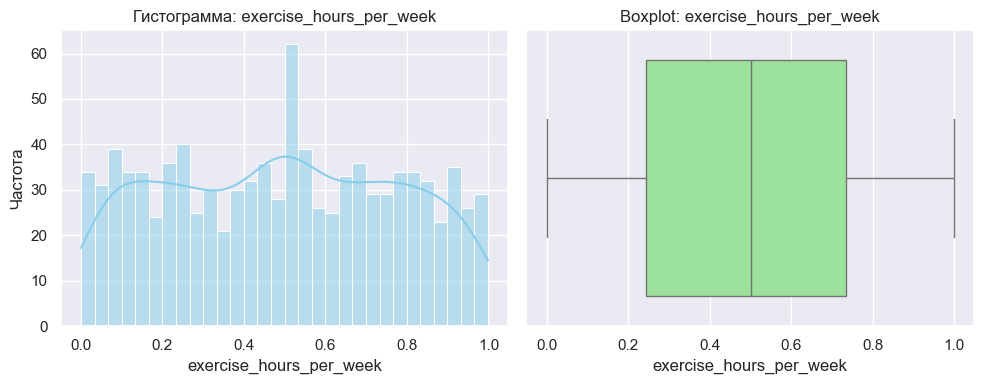

In [517]:
plot_numeric_distribution(test, 'exercise_hours_per_week')

### Анализ числового признака: `exercise_hours_per_week`

#### Гистограмма
- **Test**: распределение значений близко к равномерному по диапазону [0, 1].  
- Отмечается небольшой локальный пик в районе 0.5.  
- Значения охватывают весь диапазон, без резких разрывов.  

#### Boxplot
- Медиана находится около 0.5.  
- Межквартильный размах: примерно 0.25–0.75.  
- Минимум и максимум соответствуют границам [0, 1], выбросов не выявлено.  

#### Сравнение с train
- В train также наблюдается равномерное распределение и пик в районе 0.5.  
- Форма распределений совпадает, различия объясняются лишь размером выборки.  

#### Вывод
- Признак `exercise_hours_per_week` одинаково распределён в train и test.  

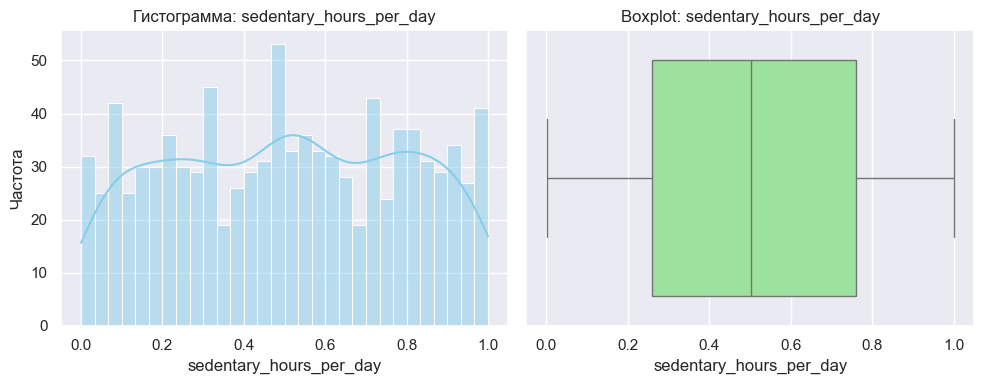

In [518]:
plot_numeric_distribution(test, 'sedentary_hours_per_day')

### Анализ числового признака: `sedentary_hours_per_day`

#### Гистограмма
- **Test**: значения распределены относительно равномерно по диапазону [0, 1].  
- Наблюдается небольшой локальный пик около 0.5.  
- Данных с экстремальными значениями почти нет.  

#### Boxplot
- Медиана находится около 0.5.  
- Межквартильный размах — примерно от 0.25 до 0.75.  
- Выбросы отсутствуют, значения распределены равномерно.  

#### Сравнение с train
- В train наблюдалось аналогичное распределение: равномерная форма с акцентом на середину.  
- Существенных отличий между выборками нет, характер распределения совпадает.  

#### Вывод
- Признак `sedentary_hours_per_day` демонстрирует одинаковое распределение в train и test.  

In [519]:
train['heart_attack_risk_(binary)'].value_counts(normalize=True)

heart_attack_risk_(binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64

## Анализ баланса классов и выбор метрик

### Баланс классов
- Класс **0 (нет риска)**: ~65%  
- Класс **1 (риск есть)**: ~35%  

Датасет **умеренно несбалансирован**.

- **Accuracy** – можно использовать, но не основная метрика (будет завышаться за счёт класса 0).  
- **Recall (чувствительность)** – ключевая метрика, так как в медицине критично **не пропустить пациентов с риском**.  
- **Precision** – дополнительная метрика, чтобы контролировать уровень ложных срабатываний.  
- **ROC-AUC** – хорошо подходит, так как классы относительно сбалансированы.  
- **PR-AUC** (Precision-Recall AUC) – более информативен для оценки качества модели по положительному классу.  

### Итог
- Основные метрики: **Recall + ROC-AUC**.  
- Дополнительные: **Precision, PR-AUC**.  
- Приоритет стратегии: **максимизировать Recall**, сохранив приемлемый Precision.

## Выбор модели

In [520]:
# ---------------- 1. Целевая переменная ----------------
target = "heart_attack_risk_(binary)"

X = df_no_missing.drop(columns=[target, "id"])
y = df_no_missing[target]

# бинарные признаки (0/1)
binary_cols = [
    "gender", "diabetes", "family_history", "smoking", 
    "obesity", "alcohol_consumption", 
    "previous_heart_problems", "medication_use"
]

# числовые признаки
num_columns = [c for c in X.columns if c not in binary_cols]

# ---------------- 2. Препроцессинг ----------------
preprocessor = ColumnTransformer([
    ("binary", "passthrough", binary_cols),
    ("num", "passthrough", num_columns)
])

# ---------------- 3. Pipeline ----------------
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier())
])

# ---------------- 4. GridSearchCV ----------------
param_grid = [
    {   # Random Forest
        "model": [RandomForestClassifier(class_weight="balanced", random_state=42)],
        "model__n_estimators": [200, 400],
        "model__max_depth": [8, 12],
        "model__min_samples_split": [3, 6],
        "model__min_samples_leaf": [2, 4]
    },
    {   # Logistic Regression
        "model": [LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=200)],
        "model__C": [0.01, 0.1, 1, 10]
    }
]

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

# ---------------- 5. Train/valid split ----------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший ROC-AUC (CV):", round(grid.best_score_, 3))

# ---------------- 6. Проверка на валидации ----------------
best_model = grid.best_estimator_

y_pred = best_model.predict(X_valid)
y_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nМетрики на валидации:")
print("ROC-AUC:", round(roc_auc_score(y_valid, y_proba), 3))
print("Accuracy:", round(accuracy_score(y_valid, y_pred), 3))
print("Precision:", round(precision_score(y_valid, y_pred), 3))
print("Recall:", round(recall_score(y_valid, y_pred), 3))
print("F1:", round(f1_score(y_valid, y_pred), 3))

print("\nClassification report:\n", classification_report(y_valid, y_pred))

# ---------------- 7. Финальная модель на всём df_no_missing ----------------
best_model.fit(X, y)

# ---------------- 8. Предсказания для test ----------------
X_test = test.drop(columns=["id"])
test_pred = best_model.predict(X_test)

submission = pd.DataFrame({
    "id": test["id"],
    "prediction": test_pred
})

submission.to_csv("submission.csv", index=False)
print("Файл submission.csv сохранён!")
print(submission.head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=RandomForestClassifier(class_weight='balanced', random_state=42), model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=3, model__n_estimators=200; total time=   1.4s
[CV] END model=RandomForestClassifier(class_weight='balanced', random_state=42), model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=6, model__n_estimators=200; total time=   1.5s
[CV] END model=RandomForestClassifier(class_weight='balanced', random_state=42), model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=6, model__n_estimators=200; total time=   1.4s
[CV] END model=RandomForestClassifier(class_weight='balanced', random_state=42), model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=3, model__n_estimators=200; total time=   1.5s
[CV] END model=RandomForestClassifier(class_weight='balanced', random_state=42), model__max_depth=8, model__min_samples_leaf=2, model__min

In [521]:
# вероятности принадлежности к классу 1
y_proba = best_model.predict_proba(X_valid)[:, 1]

results = []
thresholds = np.arange(0.1, 1.0, 0.1)

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    results.append({
        "threshold": round(thr, 2),
        "accuracy": round(accuracy_score(y_valid, y_pred_thr), 3),
        "precision": round(precision_score(y_valid, y_pred_thr), 3),
        "recall": round(recall_score(y_valid, y_pred_thr), 3),
        "f1": round(f1_score(y_valid, y_pred_thr), 3),
        "roc_auc": round(roc_auc_score(y_valid, y_proba), 3)  # не зависит от порога
    })

df_results = pd.DataFrame(results)
print(df_results)

   threshold  accuracy  precision  recall     f1  roc_auc
0        0.1     0.357      0.357   1.000  0.526      1.0
1        0.2     0.358      0.357   1.000  0.527      1.0
2        0.3     0.396      0.371   1.000  0.542      1.0
3        0.4     0.643      0.500   1.000  0.667      1.0
4        0.5     0.993      0.990   0.992  0.991      1.0
5        0.6     0.715      1.000   0.201  0.334      1.0
6        0.7     0.645      1.000   0.007  0.013      1.0
7        0.8     0.643      0.000   0.000  0.000      1.0
8        0.9     0.643      0.000   0.000  0.000      1.0


/Users/fraktalmaker/PycharmProjects/vsproj/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fraktalmaker/PycharmProjects/vsproj/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


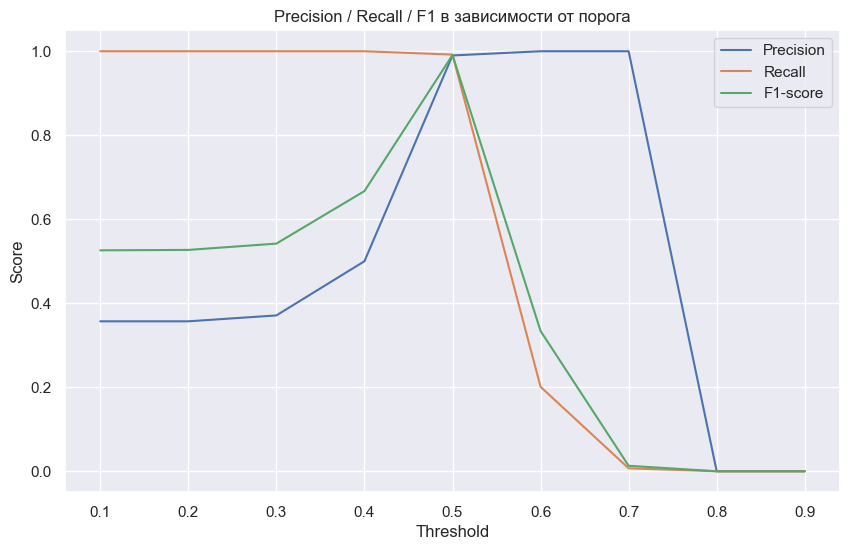

In [522]:
plt.figure(figsize=(10,6))
plt.plot(df_results["threshold"], df_results["precision"], label="Precision")
plt.plot(df_results["threshold"], df_results["recall"], label="Recall")
plt.plot(df_results["threshold"], df_results["f1"], label="F1-score")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 в зависимости от порога")
plt.legend()
plt.grid(True)
plt.show()

In [523]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# вероятности принадлежности к классу 1
y_proba = best_model.predict_proba(X_valid)[:, 1]

results = []
thresholds = np.arange(0.30, 0.41, 0.01)  # диапазон от 0.30 до 0.40

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    results.append({
        "threshold": round(thr, 2),
        "accuracy": round(accuracy_score(y_valid, y_pred_thr), 3),
        "precision": round(precision_score(y_valid, y_pred_thr), 3),
        "recall": round(recall_score(y_valid, y_pred_thr), 3),
        "f1": round(f1_score(y_valid, y_pred_thr), 3),
        "roc_auc": round(roc_auc_score(y_valid, y_proba), 3)  # не зависит от порога
    })

df_results_zoom = pd.DataFrame(results)
print(df_results_zoom)

    threshold  accuracy  precision  recall     f1  roc_auc
0        0.30     0.396      0.371     1.0  0.542      1.0
1        0.31     0.410      0.377     1.0  0.548      1.0
2        0.32     0.423      0.382     1.0  0.553      1.0
3        0.33     0.439      0.389     1.0  0.560      1.0
4        0.34     0.460      0.398     1.0  0.569      1.0
5        0.35     0.483      0.409     1.0  0.580      1.0
6        0.36     0.502      0.418     1.0  0.589      1.0
7        0.37     0.532      0.433     1.0  0.604      1.0
8        0.38     0.565      0.451     1.0  0.621      1.0
9        0.39     0.601      0.472     1.0  0.641      1.0
10       0.40     0.643      0.500     1.0  0.667      1.0


    threshold  accuracy  precision  recall     f1  roc_auc
0        0.30     0.396      0.371     1.0  0.542      1.0
1        0.31     0.410      0.377     1.0  0.548      1.0
2        0.32     0.423      0.382     1.0  0.553      1.0
3        0.33     0.439      0.389     1.0  0.560      1.0
4        0.34     0.460      0.398     1.0  0.569      1.0
5        0.35     0.483      0.409     1.0  0.580      1.0
6        0.36     0.502      0.418     1.0  0.589      1.0
7        0.37     0.532      0.433     1.0  0.604      1.0
8        0.38     0.565      0.451     1.0  0.621      1.0
9        0.39     0.601      0.472     1.0  0.641      1.0
10       0.40     0.643      0.500     1.0  0.667      1.0


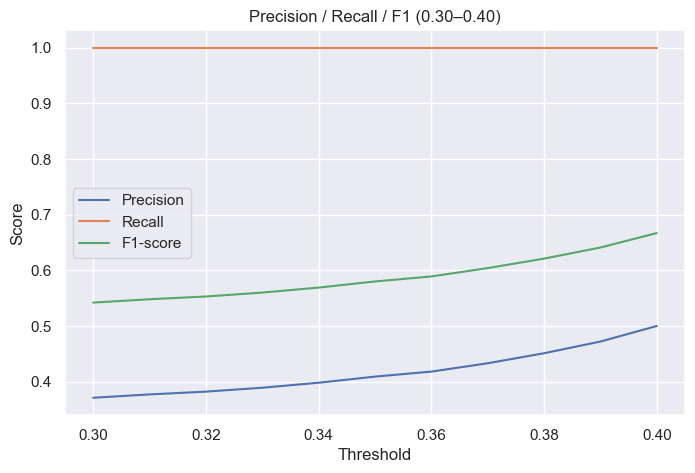

In [524]:
# вероятности для валидационной выборки
y_proba = best_model.predict_proba(X_valid)[:, 1]

# перебор порогов от 0.30 до 0.40 с шагом 0.01
thresholds = np.arange(0.30, 0.41, 0.01)
results = []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    results.append({
        "threshold": round(thr, 2),
        "accuracy": round(accuracy_score(y_valid, y_pred_thr), 3),
        "precision": round(precision_score(y_valid, y_pred_thr), 3),
        "recall": round(recall_score(y_valid, y_pred_thr), 3),
        "f1": round(f1_score(y_valid, y_pred_thr), 3),
        "roc_auc": round(roc_auc_score(y_valid, y_proba), 3)  # не зависит от порога
    })

df_results_zoom = pd.DataFrame(results)
print(df_results_zoom)

# график
plt.figure(figsize=(8,5))
plt.plot(df_results_zoom["threshold"], df_results_zoom["precision"], label="Precision")
plt.plot(df_results_zoom["threshold"], df_results_zoom["recall"], label="Recall")
plt.plot(df_results_zoom["threshold"], df_results_zoom["f1"], label="F1-score")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 (0.30–0.40)")
plt.legend()
plt.grid(True)
plt.show()

In [527]:
# ---------------- 1. Предсказания вероятностей ----------------
y_proba = best_model.predict_proba(X_valid)[:, 1]

# ---------------- 2. Фиксируем порог ----------------
threshold = 0.40
y_pred_thresh = (y_proba >= threshold).astype(int)

# ---------------- 3. Метрики ----------------
print(f"Метрики на валидации при threshold={threshold}:")
print("ROC-AUC:", round(roc_auc_score(y_valid, y_proba), 3))
print("Accuracy:", round(accuracy_score(y_valid, y_pred_thresh), 3))
print("Precision:", round(precision_score(y_valid, y_pred_thresh), 3))
print("Recall:", round(recall_score(y_valid, y_pred_thresh), 3))
print("F1:", round(f1_score(y_valid, y_pred_thresh), 3))
print("\nClassification report:\n", classification_report(y_valid, y_pred_thresh))

# ---------------- 4. Финальное обучение на всем train ----------------
X_full = df_no_missing.drop(columns=[target, "id"])
y_full = df_no_missing[target]
best_model.fit(X_full, y_full)

# ---------------- 5. Предсказания для test ----------------
# список признаков из train
train_features = df_no_missing.drop(columns=[target, "id"]).columns

# копия test
X_test = test.copy()

# убираем служебные колонки
X_test = X_test.drop(columns=["Unnamed: 0"], errors="ignore")

# добавляем недостающие как NaN
for col in train_features:
    if col not in X_test.columns:
        X_test[col] = np.nan

# оставляем только train_features
X_test = X_test[train_features]

# предсказания
test_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= threshold).astype(int)

submission = pd.DataFrame({
    "id": test["id"],
    "prediction": test_pred
})

submission.to_csv("submission.csv", index=False)
print("Файл submission.csv сохранён!")
print(submission.head())

Метрики на валидации при threshold=0.4:
ROC-AUC: 1.0
Accuracy: 0.643
Precision: 0.5
Recall: 1.0
F1: 0.667

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.44      0.62      1086
         1.0       0.50      1.00      0.67       603

    accuracy                           0.64      1689
   macro avg       0.75      0.72      0.64      1689
weighted avg       0.82      0.64      0.63      1689

Файл submission.csv сохранён!
     id  prediction
0  7746           1
1  4202           1
2  6632           1
3  4639           0
4  4825           1


In [528]:
# Сохраняем
joblib.dump(best_model, "model.pkl")

# Загружаем (проверка)
loaded_model = joblib.load("model.pkl")
print("Проверка:", loaded_model.predict(X_valid.head(5)))

Проверка: [0. 0. 0. 0. 0.]
